# This notebook trains a model with additional loss for Sufficiency on Citeseer

In [1]:
import pandas as pd
import torch_geometric
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import numpy as np
import torch
dataset = Planetoid(root='/tmp/Citeseer/', name='Citeseer')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import torch
import torch.nn.functional as F
from typing import Tuple
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import k_hop_subgraph, to_undirected
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.data import Data
from graphxai.explainers._base import _BaseExplainer

import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph



class _BaseExplainer:
    """
    Base Class for Explainers
    """
    def __init__(self,
            model: nn.Module,
            emb_layer_name: Optional[str] = None,
            is_subgraphx: Optional[bool] = False
        ):
        """
        Args:
            model (torch.nn.Module): model on which to make predictions
                The output of the model should be unnormalized class score.
                For example, last layer = GCNConv or Linear.
            emb_layer_name (str, optional): name of the embedding layer
                If not specified, use the last but one layer by default.
        """
        self.model = model
        self.L = len([module for module in self.model.modules()
                      if isinstance(module, MessagePassing)])
        self.explain_graph = False  # Assume node-level explanation by default
        self.subgraphx_flag = is_subgraphx
        self.__set_embedding_layer(emb_layer_name)

    def __set_embedding_layer(self, emb_layer_name: str = None):
        """
        Set the embedding layer (by default is the last but one layer).
        """
        if emb_layer_name:
            try:
                self.emb_layer = getattr(self.model, emb_layer_name)
            except AttributeError:
                raise ValueError(f'{emb_layer_name} does not exist in the model')
        else:
            self.emb_layer = list(self.model.modules())[-2]

    def _get_embedding(self, x: torch.Tensor, edge_index: torch.Tensor,
                       forward_kwargs: dict = {}):
        """
        Get the embedding.
        """
        emb = self._get_activation(self.emb_layer, x, edge_index, forward_kwargs)
        return emb

    def _set_masks(self, x: torch.Tensor, edge_index: torch.Tensor,
                   edge_mask: torch.Tensor = None, explain_feature: bool = False,
                   device = None):
        """
        Initialize the edge (and feature) masks.
        """
        (n, d), m = x.shape, edge_index.shape[1]

        # Initialize edge_mask and feature_mask for learning
        std = torch.nn.init.calculate_gain('relu') * np.sqrt(2.0 / (2 * n))
        if edge_mask is None:
            edge_mask = (torch.randn(m) * std).to(device)
            self.edge_mask = torch.nn.Parameter(edge_mask)
        else:
            self.edge_mask = torch.nn.Parameter(edge_mask)
        if explain_feature:
            feature_mask = (torch.randn(d) * 0.1).to(device)
            self.feature_mask = torch.nn.Parameter(feature_mask)

        self.loop_mask = edge_index[0] != edge_index[1]

        # Tell pytorch geometric to apply edge masks
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask
                module.__loop_mask__ = self.loop_mask

    def _clear_masks(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.edge_mask = None
        self.feature_mask = None

    def _flow(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def _predict(self, x: torch.Tensor, edge_index: torch.Tensor,
                 return_type: str = 'label', forward_kwargs: dict = {}):
        """
        Get the model's prediction.

        Args:
            x (torch.Tensor, [n x d]): node features
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            return_type (str): one of ['label', 'prob', 'log_prob']
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            pred (torch.Tensor, [n x ...]): model prediction
        """
        # Compute unnormalized class score
        with torch.no_grad():
            out = self.model.to(device)(x, edge_index, **forward_kwargs)
            if return_type == 'label':
                out = out.argmax(dim=-1)
            elif return_type == 'prob':
                out = F.softmax(out, dim=-1)
            elif return_type == 'log_prob':
                out = F.log_softmax(out, dim=-1)
            else:
                raise ValueError("return_type must be 'label', 'prob', or 'log_prob'")

            if self.explain_graph:
                out = out.squeeze()

            return out

    def _prob_score_func_graph(self, target_class: torch.Tensor):
        """
        Get a function that computes the predicted probability that the input graphs
        are classified as target classes.

        Args:
            target_class (int): the targeted class of the graph

        Returns:
            get_prob_score (callable): the probability score function
        """
        def get_prob_score(x: torch.Tensor,
                           edge_index: torch.Tensor,
                           forward_kwargs: dict = {}):
            prob = self._predict(x, edge_index, return_type='prob',
                                 forward_kwargs=forward_kwargs)
            score = prob[:, target_class]
            return score

        return get_prob_score

    def _prob_score_func_node(self, node_idx: torch.Tensor, target_class: torch.Tensor):
        """
        Get a function that computes the predicted probabilities that k specified nodes
        in `torch_geometric.data.Batch` (disconnected union of the input graphs)
        are classified as target classes.

        Args:
            node_idx (torch.Tensor, [k]): the indices of the k nodes interested
            target_class (torch.Tensor, [k]): the targeted classes of the k nodes

        Returns:
            get_prob_score (callable): the probability score function
        """
        if self.subgraphx_flag:
            def get_prob_score(x: torch.Tensor,
                            edge_index: torch.Tensor,
                            forward_kwargs: dict = {}):
                prob = self._predict(x, edge_index, return_type='prob',
                                    forward_kwargs=forward_kwargs)
                score = prob[node_idx, target_class]
                return score
        else:
            def get_prob_score(x: torch.Tensor,
                            edge_index: torch.Tensor,
                            forward_kwargs: dict = {}):
                prob = self._predict(x, edge_index, return_type='prob',
                                    forward_kwargs=forward_kwargs)
                score = prob[:, node_idx, target_class]
                return score

        return get_prob_score

    def _get_activation(self, layer: nn.Module, x: torch.Tensor,
                        edge_index: torch.Tensor, forward_kwargs: dict = {}):
        """
        Get the activation of the layer.
        """
        activation = {}
        def get_activation():
            def hook(model, inp, out):
                activation['layer'] = out.detach()
            return hook

        layer.register_forward_hook(get_activation())

        with torch.no_grad():
            _ = self.model(x, edge_index, **forward_kwargs)

        return activation['layer']

    def _get_k_hop_subgraph(self, node_idx: int, x: torch.Tensor,
                            edge_index: torch.Tensor, num_hops: int = None, **kwargs):
        """
        Extract the subgraph of target node

        Args:
            node_idx (int): the node index
            x (torch.Tensor, [n x d]): node feature matrix with shape
            edge_index (torch.Tensor, [2 x m]): edge index
            kwargs (dict): additional parameters of the graph

        Returns:
        """
        # TODO: use NamedTuple
        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, num_hops, edge_index,
                           relabel_nodes=True, num_nodes=x.shape[0])
        return khop_info

    def get_explanation_node(self, node_idx: int,
                             x: torch.Tensor,
                             edge_index: torch.Tensor,
                             label: torch.Tensor = None,
                             num_hops: int = None,
                             forward_kwargs: dict = {}):
        """
        Explain a node prediction.

        Args:
            node_idx (int): index of the node to be explained
            x (torch.Tensor, [n x d]): node features
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            label (torch.Tensor, optional, [n x ...]): labels to explain
                If not provided, we use the output of the model.
            num_hops (int, optional): number of hops to consider
                If not provided, we use the number of graph layers of the GNN.
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            exp (dict):
                exp['feature_imp'] (torch.Tensor, [d]): feature mask explanation
                exp['edge_imp'] (torch.Tensor, [m]): k-hop edge importance
                exp['node_imp'] (torch.Tensor, [m]): k-hop node importance
            khop_info (4-tuple of torch.Tensor):
                0. the nodes involved in the subgraph
                1. the filtered `edge_index`
                2. the mapping from node indices in `node_idx` to their new location
                3. the `edge_index` mask indicating which edges were preserved
        """
        # If labels are needed
        label = self._predict(x, edge_index, return_type='label') if label is None else label
        # If probabilities / log probabilities are needed
        prob = self._predict(x, edge_index, return_type='prob')
        log_prob = self._predict(x, edge_index, return_type='log_prob')

        num_hops = self.L if num_hops is None else num_hops

        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, num_hops, edge_index,
                           relabel_nodes=True, num_nodes=x.shape[0])
        sub_x = x[subset]

        exp = {'feature_imp': None, 'edge_imp': None}

        # Compute exp
        raise NotImplementedError()

        return exp, khop_info

    def get_explanation_graph(self, edge_index: torch.Tensor,
                              x: torch.Tensor, label: torch.Tensor,
                              forward_kwargs: dict = {}):
        """
        Explain a whole-graph prediction.

        Args:
            edge_index (torch.Tensor, [2 x m]): edge index of the graph
            x (torch.Tensor, [n x d]): node features
            label (torch.Tensor, [n x ...]): labels to explain
            forward_kwargs (dict, optional): additional arguments to model.forward
                beyond x and edge_index

        Returns:
            exp (dict):
                exp['feature_imp'] (torch.Tensor, [d]): feature mask explanation
                exp['edge_imp'] (torch.Tensor, [m]): k-hop edge importance
                exp['node_imp'] (torch.Tensor, [m]): k-hop node importance
        """
        exp = {'feature_imp': None, 'edge_imp': None}

        # Compute exp
        raise NotImplementedError()

    def get_explanation_link(self):
        """
        Explain a link prediction.
        """
        raise NotImplementedError()

from graphxai.utils import Explanation
from typing import List, Tuple, Dict

from math import sqrt
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph as subgraph

class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

class _BaseDecomposition(_BaseExplainer):
    '''
    Code adapted from Dive into Graphs (DIG)
    Code: https://github.com/divelab/DIG
    '''

    def __init__(self, model: nn.Module):
        super().__init__(model=model) # Will set self.model = model
        # Other properties: self.L (number of layers)

    @property
    def __num_hops__(self):
        if self.explain_graph:
            return -1
        else:
            return self.L
    
    def set_graph_attr(self,
                x: Tensor,
                edge_index: Tensor,
                **kwargs
                ):
        self.num_edges = edge_index.shape[1]
        self.num_nodes = x.shape[0]
        self.device = x.device

    def extract_step(self, x: Tensor, edge_index: Tensor, detach: bool = True, split_fc: bool = False, forward_kwargs: dict = None):
        '''Gets information about every layer in the graph
        Args:

            forward_kwargs (tuple, optional): Additional arguments to model forward call (other than x and edge_index)
                (default: :obj:`None`)
        '''

        layer_extractor = []
        hooks = []

        def register_hook(module: nn.Module):
            if not list(module.children()) or isinstance(module, MessagePassing):
                hooks.append(module.register_forward_hook(forward_hook))

        def forward_hook(module: nn.Module, input: Tuple[Tensor], output: Tensor):
            # input contains x and edge_index
            if detach:
                layer_extractor.append((module, input[0].clone().detach(), output.clone().detach()))
            else:
                layer_extractor.append((module, input[0], output))

        # --- register hooks ---
        self.model.apply(register_hook)

        # ADDED: OWEN QUEEN --------------
        if forward_kwargs is None:
            _ = self.model(x, edge_index)
        else:
            _ = self.model(x, edge_index, **forward_kwargs)
        # --------------------------------
        # Remove hooks:
        for hook in hooks:
            hook.remove()

        # --- divide layer sets ---

        # print('Layer extractor', [layer_extractor[i][0] for i in range(len(layer_extractor))])

        walk_steps = []
        fc_steps = []
        pool_flag = False
        step = {'input': None, 'module': [], 'output': None}
        for layer in layer_extractor:
            if isinstance(layer[0], MessagePassing):
                if step['module']: # Append step that had previously been building
                    walk_steps.append(step)

                step = {'input': layer[1], 'module': [], 'output': None}

            elif isinstance(layer[0], GNNPool):
                pool_flag = True
                if step['module']:
                    walk_steps.append(step)

                # Putting in GNNPool
                step = {'input': layer[1], 'module': [], 'output': None}

            elif isinstance(layer[0], nn.Linear):
                if step['module']:
                    if isinstance(step['module'][0], MessagePassing):
                        walk_steps.append(step) # Append MessagePassing layer to walk_steps
                    else: # Always append Linear layers to fc_steps
                        fc_steps.append(step)

                step = {'input': layer[1], 'module': [], 'output': None}

            # Also appends non-trainable layers to step (not modifying input):
            step['module'].append(layer[0])
            step['output'] = layer[2]

        if step['module']:
            if isinstance(step['module'][0], MessagePassing):
                walk_steps.append(step)
            else: # Append anything to FC that is not MessagePassing at its origin
                # Still supports sequential layers
                fc_steps.append(step)
            # print('layer', layer[0])
            # if isinstance(layer[0], MessagePassing) or isinstance(layer[0], GNNPool):
            #     if isinstance(layer[0], GNNPool):
            #         pool_flag = True
            #     if step['module'] and step['input'] is not None:
            #         walk_steps.append(step)
            #     step = {'input': layer[1], 'module': [], 'output': None}
            # if pool_flag and split_fc and isinstance(layer[0], nn.Linear):
            #     if step['module']:
            #         fc_steps.append(step)
            #     step = {'input': layer[1], 'module': [], 'output': None}
            # step['module'].append(layer[0])
            # step['output'] = layer[2]

        for walk_step in walk_steps:
            if hasattr(walk_step['module'][0], 'nn') and walk_step['module'][0].nn is not None:
                # We don't allow any outside nn during message flow process in GINs
                walk_step['module'] = [walk_step['module'][0]]
            elif hasattr(walk_step['module'][0], 'lin') and walk_step['module'][0].lin is not None:
                walk_step['module'] = [walk_step['module'][0]]

        # print('Walk steps', [walk_steps[i]['module'] for i in range(len(walk_steps))])
        # print('fc steps', [fc_steps[i]['module'] for i in range(len(fc_steps))])

        return walk_steps, fc_steps

    def walks_pick(self,
                   edge_index: Tensor,
                   pick_edge_indices: List,
                   walk_indices: List=[],
                   num_layers=0
                   ):
        walk_indices_list = []
        for edge_idx in pick_edge_indices:

            # Adding one edge
            walk_indices.append(edge_idx)
            _, new_src = src, tgt = edge_index[:, edge_idx]
            next_edge_indices = np.array((edge_index[0, :] == new_src).nonzero().view(-1))

            # Finding next edge
            if len(walk_indices) >= num_layers:
                # return one walk
                walk_indices_list.append(walk_indices.copy())
            else:
                walk_indices_list += self.walks_pick(edge_index, next_edge_indices, walk_indices, num_layers)

            # remove the last edge
            walk_indices.pop(-1)

        return walk_indices_list

class CAM(_BaseDecomposition):
    '''
    Class-Activation Mapping for GNNs
    '''

    def __init__(self, model: torch.nn.Module, activation = None):
        '''
        .. note::
            From Pope et al., CAM requires that the layer immediately before the softmax layer be
            a global average pooling layer, or in the case of node classification, a graph convolutional
            layer. Therefore, for this algorithm to theoretically work, there can be no fully-connected
            layers after global pooling. There is no restriction in the code for this, but be warned. 

        Args:
            model (torch.nn.Module): model on which to make predictions
            activation (method, optional): activation funciton for final layer in network. If `activation = None`,
                explainer assumes linear activation. Use `activation = None` if the activation is applied
                within the `forward` method of `model`, only set this parameter if another activation is
                applied in the training procedure outside of model. (:default: :obj:`None`)
        '''
        super().__init__(model=model)
        self.model = model

        # Set activation function
        self.activation = lambda x: x  if activation is None else activation
        # i.e. linear activation if none provided

    def get_explanation_node(self, 
                x: torch.Tensor, 
                node_idx: int, 
                edge_index: torch.Tensor, 
                label: int = None,  
                y = None,
                forward_kwargs: dict = {},
                directed: bool = False
            ) -> Explanation:
        '''
        Explain one node prediction by the model

        Args:
            x (torch.tensor): tensor of node features from the entire graph
            node_idx (int): node index for which to explain a prediction around
            edge_index (torch.tensor): edge_index of entire graph
            label (int, optional): Label on which to compute the explanation for
                this node. If `None`, the predicted label from the model will be
                used. (default: :obj:`None`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)
            directed (bool, optional): If True, graph is directed.

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        if not directed:
            edge_index = to_undirected(edge_index)

        if label is None:
            if y is None:
                label = int(self.__forward_pass(x, edge_index, forward_kwargs).argmax(dim=1).item())
            else:
                label = y[node_idx]

        # Perform walk:
        walk_steps, _ = self.extract_step(x, edge_index, detach=False, split_fc=False, forward_kwargs = forward_kwargs)

        # Get subgraph:
        khop_info = k_hop_subgraph(node_idx = node_idx, num_hops = self.L, edge_index = edge_index)
        subgraph_nodes = khop_info[0]

        N = maybe_num_nodes(edge_index, None)
        subgraph_N = len(subgraph_nodes.tolist())

        #cam = torch.zeros(N) # Compute CAM only over the subgraph (all others are zero)
        cam = torch.zeros(subgraph_N)
        for i in range(subgraph_N):
            n = subgraph_nodes[i]
            cam[i] += self.__exp_node(n, walk_steps, label)

        # Set Explanation class:
        exp = Explanation(
            node_imp = cam,
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)

        return exp

    def __forward_pass(self, x, edge_index, forward_kwargs = {}):
        # Forward pass:
        self.model.eval()
        pred = self.model(x, edge_index, **forward_kwargs)

        return pred

    def __exp_node(self, node_idx, walk_steps, predicted_c):
        '''
        Gets explanation for one node
        Assumes ReLU activation after last convolutiuonal layer
        TODO: Fix activation function assumption
        '''
        last_conv_layer = walk_steps[-1]

        if isinstance(last_conv_layer['module'][0], GINConv):
            weight_vec = last_conv_layer['module'][0].nn.weight[predicted_c, :].detach()  # last_conv_layer['module'][0].lin.weight[predicted_c, :].detach()
        elif isinstance(last_conv_layer['module'][0], GCNConv):
            weight_vec = last_conv_layer['module'][0].lin.weight[predicted_c, :].detach()
        elif isinstance(last_conv_layer['module'][0], torch.nn.Linear):
            weight_vec = last_conv_layer['module'][0].weight[predicted_c, :].detach()

        F_l_n = F.relu(last_conv_layer['input'][node_idx,:]).detach()

        L_cam_n = F.relu(torch.matmul(weight_vec, F_l_n))

        return L_cam_n.item()


class GradCAM(_BaseDecomposition):
    '''
    Gradient Class-Activation Mapping for GNNs
    '''

    def __init__(self, model: torch.Tensor, criterion = F.cross_entropy):
        '''
        Args:
            model (torch.nn.Module): model on which to make predictions
            criterion (PyTorch Loss Function): loss function used to train the model.
                Needed to pass gradients backwards in the network to obtain gradients.
        '''
        super().__init__(model)
        self.model = model
        self.criterion = criterion

    def get_explanation_node(self, 
            x: torch.Tensor, 
            y: torch.Tensor, 
            node_idx: int, 
            edge_index: torch.Tensor, 
            label: int = None, 
            forward_kwargs: dict = {}, 
            average_variant: bool = True, 
            layer: int = 0
        ) -> Explanation:
        '''
        Explain a node in the given graph
        Args:
            x (torch.Tensor, (n,)): Tensor of node features from the entire graph, with n nodes.
            y (torch.Tensor, (n,)): Ground-truth labels for all n nodes in the graph.
            node_idx (int): node index for which to explain a prediction around
            edge_index (torch.Tensor): Edge_index of entire graph.
            label (int, optional): Label for which to compute Grad-CAM against. If None, computes
                the Grad-CAM with respect to the model's predicted class for this node.
                (default :obj:`None`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. (default: :obj:`None`)
            average_variant (bool, optional): If True, computes the average Grad-CAM across all convolutional
                layers in the model. If False, computes Grad-CAM for `layer`. (default: :obj:`True`)
            layer (int, optional): Layer by which to compute the Grad-CAM. Argument only has an effect if 
                `average_variant == True`. Must be less-than the total number of convolutional layers
                in the model. (default: :obj:`0`)

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        x = x.detach().clone()
        y = y.detach().clone()

        x.requires_grad = True

        if label is None:
            pred = self.__forward_pass(x, y, edge_index, forward_kwargs)[0][node_idx, :].reshape(1, -1)
            y[node_idx] = pred.argmax(dim=1).item()
        else: # Transform node_idx's label if provided by user
            pred, loss = self.__forward_pass(x, y, edge_index, forward_kwargs)
            y[node_idx] = label

        walk_steps, _ = self.extract_step(x, edge_index, detach=True, split_fc=True, forward_kwargs = forward_kwargs)

        khop_info = k_hop_subgraph(node_idx, self.L, edge_index)
        subgraph_nodes = khop_info[0]

        N = maybe_num_nodes(edge_index, None)
        subgraph_N = len(subgraph_nodes.tolist())

        exp = Explanation(
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)

        if average_variant:
            # Size of all nodes in the subgraph:
            avg_gcam = torch.zeros(subgraph_N)

            for l in range(self.L):
                # Compute gradients for this layer ahead of time:
                gradients = self.__grad_by_layer(l)

                for i in range(subgraph_N): # Over all subgraph nodes
                    n = subgraph_nodes[i]
                    avg_gcam[i] += self.__get_gCAM_layer(walk_steps, l, n, gradients)

            avg_gcam /= self.L # Apply average

            exp.node_imp = avg_gcam

        else:
            assert layer < len(walk_steps), "Layer must be an index of convolutional layers"

            gcam = torch.zeros(subgraph_N)
            gradients = self.__grad_by_layer(layer)
            for i in range(subgraph_N):
                n = subgraph_nodes[i]
                gcam[i] += self.__get_gCAM_layer(walk_steps, layer, n, gradients)#[0]

            exp.node_imp = gcam

        return exp
        
    def __forward_pass(self, x, label, edge_index, forward_kwargs):
        x.requires_grad = True # Enforce that x needs gradient

        # Forward pass:
        self.model.eval()
        pred = self.model(x, edge_index, **forward_kwargs)

        loss = self.criterion(pred, label)
        loss.backward() # Propagate loss backward through network

        return pred, loss

    def __grad_by_layer(self, layer):
        # Index 0 of parameters to avoid calculating gradients for biases
        module_at_layer = list(self.model.children())[layer]

        if isinstance(module_at_layer, GCNConv):
            grad = module_at_layer.lin.weight.grad
        elif isinstance(module_at_layer, GINConv):
            grad = module_at_layer.nn.weight.grad
        else:
            grad = module_at_layer.weight.grad

        return grad.mean(dim=1)

    def __get_gCAM_layer(self, walk_steps, layer, node_idx = None, gradients = None):
        # Gets Grad CAM for one layer
        if gradients is None:
            # \alpha^{l,c} = Average over nodes of gradients for layer l, after activation over c
            # ''        '' shape: [k,] - k= # output features from layer l
            gradients = self.__grad_by_layer(layer)

        if node_idx is None: # Need to compute for entire graph:
            node_explanations = []
            for n in range(self.N):
                node_explanations.append(self.__exp_node(n, walk_steps, layer, gradients))

            return node_explanations

        # Return for only one node:
        return self.__exp_node(node_idx, walk_steps, layer, gradients)

    def __exp_node(self, node_idx, walk_steps, layer, gradients):
        '''
        Gets explanation for one node
        Assumes ReLU activation after each convolutional layer
        TODO: Fix activation function assumption
        '''
        # \alpha^{l,c} = Average over nodes of gradients for layer l, after activation over c
        # ''        '' shape: [k,] - k= # input features to layer l

        # Activations for node n
        F_l_n = F.relu(walk_steps[layer]['output'][node_idx,:]).detach()
        L_cam_n = F.relu(torch.matmul(gradients, F_l_n)) # Combine gradients and activations

        return L_cam_n.item()

import torch
import torch.nn.functional as F
from typing import Tuple
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data

from graphxai.utils import Explanation
# from ._decomp_base_old import _BaseDecomposition

def clip_hook(grad):
    # Apply ReLU activation to gradient
    return torch.clamp(grad, min=0)
import gc

class GuidedBP(_BaseDecomposition):

    def __init__(self, model, criterion = F.cross_entropy, enforce_requires_grad = True):
        '''
        Args:
            model (torch.nn.Module): model on which to make predictions
            criterion (PyTorch Loss Function): loss function used to train the model.
                Needed to pass gradients backwards in the network to obtain gradients.
        '''
        super().__init__(model)
        self.model = model
        self.criterion = criterion

        self.L = len([module for module in self.model.modules() if isinstance(module, MessagePassing)])

        self.registered_hooks = []

        self.enforce_requires_grad = enforce_requires_grad

    def get_explanation_node(self, 
                x: torch.Tensor, 
                y: torch.Tensor,
                edge_index: torch.Tensor,  
                node_idx: int, 
                aggregate_node_imp = torch.sum,
                forward_kwargs: dict = {}
            ) -> Explanation:
        '''
        Get Guided Backpropagation explanation for one node in the graph
        Args:
            x (torch.tensor): tensor of node features from the entire graph
            y (torch.Tensor): Ground truth labels correspond to each node's 
                classification. This argument is input to the `criterion` 
                function provided in `__init__()`.
            edge_index (torch.tensor): Edge_index of entire graph.
            node_idx (int): node index for which to explain a prediction around
            aggregate_node_imp (function, optional): torch function that aggregates
                all node importance feature-wise scores across the enclosing 
                subgraph. Must support `dim` argument.
                (:default: :obj:`torch.sum`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop, features]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :obj:`graphxai.utils.EnclosingSubgraph`
        '''

        # Run whole-graph prediction:
        if self.enforce_requires_grad:
            try:
                x = x.detach().clone()
                x.requires_grad = True
            except:
                pass
        # assert x.requires_grad, 'x must have requires_grad == True'

        # Perform the guided backprop:
        xhook = x.register_hook(clip_hook)
        
        self.model.zero_grad()
        pred = self.__forward_pass(x, edge_index, forward_kwargs)
        loss = self.criterion(pred, y)
        self.__apply_hooks()
        loss.backward()
        self.__rm_hooks()

        xhook.remove() # Remove hook from x

        graph_exp = x.grad

        khop_info = k_hop_subgraph(node_idx = node_idx, num_hops = self.L, edge_index = edge_index)
        subgraph_nodes = khop_info[0]

        node_imp = aggregate_node_imp(torch.stack([graph_exp[i,:] for i in subgraph_nodes]).detach(), dim=1)

        # Get only those explanations for nodes in the subgraph:
        exp = Explanation(
            node_imp = node_imp,
            node_idx = node_idx
        )
        
        exp.set_enclosing_subgraph(khop_info)
        return exp

    def get_explanation_graph(self, 
                x: torch.Tensor, 
                y: torch.Tensor, 
                edge_index: torch.Tensor, 
                aggregate_node_imp = torch.sum,
                forward_kwargs: dict = {}
        ) -> Explanation:
        '''
        Explain a whole-graph prediction with Guided Backpropagation

        Args:
            x (torch.tensor): Tensor of node features from the entire graph.
            y (torch.tensor): Ground truth label of given input. This argument is 
                input to the `criterion` function provided in `__init__()`.
            edge_index (torch.tensor): Edge_index of entire graph.
            aggregate_node_imp (function, optional): torch function that aggregates
                all node importance feature-wise scores across the graph. 
                Must support `dim` argument. (:default: :obj:`torch.sum`)
            forward_kwargs (dict, optional): Additional arguments to model.forward 
                beyond x and edge_index. Must be keyed on argument name. 
                (default: :obj:`{}`)   

        :rtype: :class:`graphxai.Explanation`

        Returns:
            exp (:class:`Explanation`): Explanation output from the method. 
                Fields are:
                `feature_imp`: :obj:`None`
                `node_imp`: :obj:`torch.Tensor, [num_nodes, features]`
                `edge_imp`: :obj:`None`
                `graph`: :obj:`torch_geometric.data.Data`
        '''

        # Run whole-graph prediction:
        try:
            x.requires_grad = True
        except:
            pass

        assert x.requires_grad, 'x must have requires_grad == True' 

        # Perform the guided backprop:
        xhook = x.register_hook(clip_hook)
        
        self.model.zero_grad()
        pred = self.__forward_pass(x, edge_index, forward_kwargs)
        loss = self.criterion(pred, y)
        self.__apply_hooks()
        loss.backward()
        self.__rm_hooks()

        xhook.remove() # Remove hook from x

        node_imp = aggregate_node_imp(x.grad, dim=1)

        exp = Explanation(
            node_imp = node_imp
        )
    
        exp.set_whole_graph(Data(x, edge_index))

        return exp

    def __apply_hooks(self):
        self.registered_hooks = []
        for p in self.model.parameters():
            h = p.register_hook(clip_hook)
            self.registered_hooks.append(h)

    def __rm_hooks(self):
        for h in self.registered_hooks:
            h.remove()
        self.registered_hooks = []
    
    def __forward_pass(self, x, edge_index, forward_kwargs):
        # Forward pass:
        self.model.eval()
        self.__apply_hooks()
        pred = self.model(x, edge_index, **forward_kwargs)

        return pred
from graphxai.utils import Explanation
class IG():
    def __init__(self, model, hops: Optional[int] = 1, criterion = None):
        self.model = model
        self.num_hops = hops
        self.criterion = criterion

    def node_explanations(self, node_idx: int, 
            x: torch.Tensor,
            edge_index: torch.Tensor, 
            y: Optional[torch.Tensor] = None,):
        """
        Explain a node prediction.

        Args:
            node_idx (int): Index of the node to be explained.
            edge_index (torch.Tensor, [2 x m]): Edge index of the graph.
            x (torch.Tensor, [n x d]): Node features.
            label (torch.Tensor, [n x ...]): Labels to explain.
            y (torch.Tensor): Same as `label`, provided for general 
                compatibility in the arguments. (:default: :obj:`None`)
            num_hops (int, optional): Number of hops in the enclosing 
                subgraph. If `None`, set to the number of layers in 
                the GNN. (:default: :obj:`None`)
            steps (int, optional): Number of steps for the Riemannian 
                integration. (:default: :obj:`40`)

        Returns:
            exp (:class:`Explanation`): Explanation output from the method.
                Fields are:
                `feature_imp`: :obj:`torch.Tensor, [x.shape[1],]`
                `node_imp`: :obj:`torch.Tensor, [nodes_in_khop,]`
                `edge_imp`: :obj:`None`
                `enc_subgraph`: :class:`graphxai.utils.EnclosingSubgraph`
        """

        if (y is None):
            raise ValueError('Either label or y should be provided for Integrated Gradients')

        label = y[node_idx]
        if len(label.shape) == 0:
            label = label.unsqueeze(dim=0)

        khop_info = subset, sub_edge_index, mapping, _ = \
            k_hop_subgraph(node_idx, self.num_hops, edge_index,
                            relabel_nodes=True, num_nodes=x.shape[0])
        sub_x = x[subset]
        steps = 40
        self.model.eval()
        grads = torch.zeros(steps+1, x.shape[1]).to(device)

        # Perform Riemannian integration
        for i in range(steps+1):
            with torch.no_grad():
                baseline = torch.zeros_like(sub_x).to(device)  # TODO: baseline all 0s, all 1s, ...?
                temp_x = baseline + (float(i)/steps) * (sub_x.clone()-baseline)
            temp_x.requires_grad = True
            output = self.model(temp_x, sub_edge_index)
            loss = self.criterion(output[mapping], label)
            loss.backward()
            grad = temp_x.grad[torch.where(subset==node_idx)[0].item()]
            grads[i] = grad

        grads = (grads[:-1] + grads[1:]) / 2.0
        avg_grads = torch.mean(grads, axis=0)

        # Integrated gradients for only node_idx:
        # baseline[0] just gets a single-value 0-tensor
        integrated_gradients = ((x[torch.where(subset == node_idx)[0].item()]
                                    - baseline[0]) * avg_grads)

        # Integrated gradients across the enclosing subgraph:
        all_node_ig = ((x[subset] - baseline) * avg_grads)
        node_importances = torch.sum(all_node_ig, dim=1)
        exp = Explanation(
            feature_imp = integrated_gradients,
            node_imp = node_importances,
            node_idx = node_idx
        )
        exp.set_enclosing_subgraph(khop_info)
        gc.collect()
        return exp

c:\Users\freis\anaconda3\envs\mainEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sufficiency Function

In [3]:
import random, sys
from typing import Union, List

from networkx.classes.function import to_undirected
import networkx as nx
import ipdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from numpy import ndarray
from torch_geometric.utils import to_networkx
import gc

from graphxai.explainers import CAM, GradCAM, GNNExplainer
# from graphxai.explainers.utils.visualizations import visualize_subgraph_explanation
from graphxai.visualization.visualizations import visualize_subgraph_explanation
from graphxai.visualization.explanation_vis import visualize_node_explanation
from graphxai.gnn_models.node_classification import GCN, train, test
from graphxai.gnn_models.node_classification.testing import GCN_3layer_basic, GIN_3layer_basic

from graphxai.gnn_models.node_classification import GCN, train, test
from graphxai.gnn_models.node_classification.testing import GCN_3layer_basic, train, test

from graphxai.datasets.shape_graph import ShapeGGen
from graphxai.utils import to_networkx_conv, Explanation, distance
from graphxai.utils.perturb import rewire_edges

from scipy.spatial.distance import euclidean
from tqdm import tqdm

B = {1,5,10,20,50}
len_b = len(B)
def sufficiency(generated_exp: list, shape_graph: any, model: torch.nn.Module) -> list:
    '''
    Args:
        gt_exp (list): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    # TODO: 1) Implement perturbations for continuous and discrete node attribute features
    suff = list() # GEF = 1/m * sum(||F(x)-F(y)||) where F(x) is the original importances and F(y) is the perturbed

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    with tqdm(total=len(generated_exp)) as pbar:
        for exp in generated_exp:
            pbar.update(1)
            exp_subgraph = exp.enc_subgraph
            dist_total = 0
            for q in B:
                top_k = q / 100 # getting top k percent
                # Identifying the top_k nodes in the explanation subgraph
                top_k_nodes = exp.node_imp.topk(int(exp.node_imp.shape[0] * top_k))[1]
                rem_nodes = []
                for node in range(exp.node_imp.shape[0]):
                    if node not in top_k_nodes:
                        rem_nodes.append([k for k, v in exp.node_reference.items() if v == node][0])

                # Getting the softmax vector for the original graph
                org_vec = model(shape_graph.x, shape_graph.edge_index)[exp.node_idx]
                org_softmax = F.softmax(org_vec, dim=-1)
                # Getting the softmax vector for the perturbed graph
                pert_x = shape_graph.x.clone()

                # Removing the unimportant nodes by masking
                pert_x[rem_nodes] = torch.zeros_like(pert_x[rem_nodes])  # torch.normal(0, 0.1, pert_x[rem_nodes].shape)
                pert_vec = model(pert_x, shape_graph.edge_index)[exp.node_idx]

                # check if the graph is disconnected!!
                pert_softmax = F.softmax(pert_vec, dim=-1)

                # summing the differences between the two explanations
                dist = euclidean(org_softmax.detach().cpu().numpy(), pert_softmax.detach().cpu().numpy())

                dist_total += dist
                gc.collect()
            suff.append(dist_total / len_b)
    return suff


In [4]:
def gbp_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    bp_exps = list()
    explainability_model = GuidedBP(model=model)
    model.eval()
    with tqdm(total=len(graph.nodes())) as pbar:
        for node in graph.nodes():
            pbar.update(1)
            exp = explainability_model.get_explanation_node(node_idx=node, x=data_object.x, edge_index=data_object.edge_index, y=data_object.y)
            bp_exps.append(exp)
    return bp_exps

def cam_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    cam_exps = list()
    model.eval()
    explainability_model = CAM(model=model)
    with tqdm(total=len(graph.nodes())) as pbar:

        for node in graph.nodes():
            pbar.update(1)
            exp = explainability_model.get_explanation_node(node_idx=node, x = data_object.x, edge_index = data_object.edge_index,  y = data_object.y)
            cam_exps.append(exp)
    return cam_exps
    
def ig_exps(model: torch.nn.Module, graph, data_object: torch_geometric.data.Data)->list:
    """For all nodes, we get the explanations from the current model, returned as list"""
    explanations_list = list()
    model.eval()
    ig = IG(model=model, criterion=torch.nn.CrossEntropyLoss(), hops=1)
    with tqdm(total=len(graph.nodes())) as pbar:

        for node in graph.nodes():
            pbar.update(1)
            exp = ig.node_explanations(node_idx=node, x=data_object.x, edge_index=data_object.edge_index, y=data_object.y)
            explanations_list.append(exp)
    return explanations_list

# CAM model

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
from torcheval.metrics.functional import multiclass_f1_score

torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()
cam_sufficiency_list = list()
loss_list = list()
f1_accuracy_list = list()
with tqdm(total=100) as pbar:
    for epoch in range(100):
        pbar.update(1)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        # getting GuidedBP Explanations
        # gbp = GuidedBP(model=model)
        # getting IG explanations
        cam_explanations = cam_exps(model, graph, data)

        cam_suff = median(sufficiency(generated_exp=cam_explanations, shape_graph=data, model=model))
        print(loss)
        loss.add(cam_suff)
        print(loss)
        loss.backward()
        loss_list.append(loss)
        cam_sufficiency_list.append(cam_suff)
        optimizer.step()

        pred = out.argmax(dim=1)
        f1 = multiclass_f1_score(pred, data.y, num_classes=dataset.num_classes)
        f1_accuracy_list.append(f1)
        if(epoch % 25 == 0):
            torch.save(model, "sufficiency_100_citeseer_CAM.pt")
            df = pd.DataFrame([(loss_list[i].item(), cam_sufficiency_list[i], f1_accuracy_list[i].item()) for i in range(len(loss_list))], columns=["Loss", "CAM Sufficiency", "F1 Accuracy"])
            df.to_csv("Training_for_CAM_sufficiency_CITESEER")

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

100%|██████████| 3327/3327 [34:56<00:00,  1.59it/s]


[0.0029124800115823747, 0.0029182358644902705, 0.0035386642441153525, 0.0037010416854172945, 0.003785726986825466, 0.003854737989604473, 0.003961254796013236, 0.004081591125577688, 0.004138568555936218, 0.004172522900626063, 0.004255571030080318, 0.004263643128797412, 0.004308788711205125, 0.004320843052119017, 0.004342131409794092, 0.004414192028343677, 0.004430201649665832, 0.004434298351407051, 0.004556059278547764, 0.004556059278547764, 0.004680985026061535, 0.004725288413465023, 0.004743656562641263, 0.004749547271057963, 0.004786949325352907, 0.004801044194027782, 0.004845631029456854, 0.004904495552182198, 0.004942984273657203, 0.004955374775454402, 0.0050009461119771, 0.0050075356615707275, 0.005011390405707061, 0.005030419025570154, 0.0050593607127666475, 0.005064021190628409, 0.005065715499222278, 0.005101955402642489, 0.005104681616649032, 0.005106101278215647, 0.005134257627651096, 0.005146393598988652, 0.005215328698977828, 0.005239872960373759, 0.0053025789093226194, 0.00

  3%|▎         | 3/100 [1:10:56<40:37:58, 1508.03s/it]

[0.0022363992407917976, 0.003615636704489589, 0.003867621161043644, 0.003894920228049159, 0.004007742553949356, 0.004422533651813864, 0.004422533651813864, 0.004802698269486427, 0.00496688224375248, 0.005164334690198303, 0.005164334690198303, 0.005183758586645127, 0.005237889708951116, 0.005269949324429035, 0.005319841112941504, 0.005344481393694878, 0.0054379083216190335, 0.005477584199979901, 0.005560797918587923, 0.0056756391189992424, 0.005679503362625837, 0.0057124471291899685, 0.005836881324648857, 0.005996810225769878, 0.006006374442949891, 0.006091645592823625, 0.006099249701946974, 0.006168543919920921, 0.006199249345809221, 0.00623853150755167, 0.00623984495177865, 0.00623984495177865, 0.006382915936410427, 0.0064605833031237125, 0.006534960120916367, 0.006535129807889462, 0.0066734936088323595, 0.006897458340972662, 0.006951634678989649, 0.006963294744491577, 0.006979842996224761, 0.007019137591123581, 0.007020947523415089, 0.0070446358993649484, 0.007181871775537729, 0.0071

  4%|▍         | 4/100 [1:46:45<46:35:20, 1747.09s/it]

[0.008286001347005367, 0.010961980931460858, 0.011350507382303476, 0.011451363004744053, 0.01206349916756153, 0.012277252972126007, 0.012413570377975702, 0.013437219616025686, 0.013784774392843247, 0.013784774392843247, 0.013784774392843247, 0.0140215914696455, 0.014036775566637516, 0.01440410502254963, 0.014951302483677865, 0.014971455186605453, 0.014997289329767228, 0.015159137919545174, 0.015438957139849663, 0.015438957139849663, 0.015502286329865455, 0.015877430513501167, 0.016189061850309373, 0.016352724842727186, 0.016701764613389968, 0.016807715967297555, 0.016807715967297555, 0.016945726983249188, 0.017092209681868552, 0.01733611077070236, 0.017541908472776414, 0.01757732592523098, 0.018131830915808677, 0.01817429270595312, 0.018286176025867462, 0.018424153327941895, 0.018723275139927865, 0.018882216513156892, 0.019012545794248582, 0.01909966506063938, 0.01935092583298683, 0.019393378309905528, 0.019714364781975746, 0.01973018478602171, 0.01974874110892415, 0.01991604156792164,

  5%|▌         | 5/100 [2:22:14<49:36:34, 1879.94s/it]

[0.019552400708198546, 0.020036403834819794, 0.020036403834819794, 0.020036403834819794, 0.022856884449720383, 0.02354249358177185, 0.02403346113860607, 0.02434164397418499, 0.02575485184788704, 0.026193027943372728, 0.026690710335969925, 0.027368860319256783, 0.027938805148005487, 0.028083446994423868, 0.029625633731484413, 0.029625635221600534, 0.03149805851280689, 0.03193124309182167, 0.03196733742952347, 0.03224136978387833, 0.03236263729631901, 0.032362644001841544, 0.03241258710622787, 0.03286414369940758, 0.03317435942590237, 0.034005163609981535, 0.03409416377544403, 0.03487328663468361, 0.0349705807864666, 0.035049793869256975, 0.03510806895792484, 0.03510806895792484, 0.03543171472847462, 0.03543968945741653, 0.03589167147874832, 0.03594582974910736, 0.036388909444212914, 0.03661559000611305, 0.036648289486765864, 0.037381775304675104, 0.03783730790019035, 0.037837500870227816, 0.038034716993570326, 0.038034716993570326, 0.03828555978834629, 0.0383062282577157, 0.038370700180

  6%|▌         | 6/100 [2:57:41<51:13:42, 1961.94s/it]

[0.0323338620364666, 0.03864322751760483, 0.03892312347888947, 0.03912615105509758, 0.039627740159630775, 0.03984620720148087, 0.04127111025154591, 0.04166210368275643, 0.04314098358154297, 0.043244848400354384, 0.04357334859669208, 0.04403900355100632, 0.04403900355100632, 0.04480519071221352, 0.04490357413887978, 0.04555849954485893, 0.04687060117721557, 0.047376681864261624, 0.047376681864261624, 0.0474107451736927, 0.04751381576061249, 0.04796652570366859, 0.048444893956184384, 0.04857533946633339, 0.04874139837920666, 0.04876219481229782, 0.04885798022150993, 0.050551760196685794, 0.05071670189499855, 0.05086940042674541, 0.05115541890263557, 0.05203433874994516, 0.05241865366697311, 0.05255349352955818, 0.05324996188282967, 0.0534560963511467, 0.0537296861410141, 0.05376130416989326, 0.05378220677375793, 0.05380927547812462, 0.05421852096915245, 0.054354510456323626, 0.054844948649406436, 0.05502369999885559, 0.05507397353649139, 0.05533741712570191, 0.0553596593439579, 0.0555348

  7%|▋         | 7/100 [3:33:13<52:05:40, 2016.56s/it]

[0.048983509093523024, 0.05066416412591934, 0.050974785536527636, 0.05111694410443306, 0.0514088936150074, 0.05222891792654991, 0.053029099851846694, 0.05444468632340431, 0.05529832169413566, 0.05529832169413566, 0.05540060847997665, 0.05542837604880333, 0.05694921463727951, 0.058332827687263486, 0.05838501825928688, 0.05864153951406479, 0.05898132249712944, 0.05898132398724556, 0.05898132398724556, 0.05966081395745278, 0.06031285598874092, 0.061271656304597855, 0.061558933556079866, 0.06228095442056656, 0.06228095442056656, 0.06319193691015243, 0.06352537125349045, 0.063573107868433, 0.06376034468412399, 0.06376034468412399, 0.06376444771885872, 0.06418848261237145, 0.06510114222764969, 0.0661441557109356, 0.06633394807577134, 0.06667113378643989, 0.06696757823228836, 0.06719752177596092, 0.06719752177596092, 0.06735980659723281, 0.0677709698677063, 0.06781520470976829, 0.06878745928406715, 0.069119992852211, 0.06912737339735031, 0.06927910372614861, 0.06976088210940361, 0.06981265246

  8%|▊         | 8/100 [4:08:45<52:27:40, 2052.83s/it]

[0.0470782071352005, 0.05048334002494812, 0.052081840485334395, 0.05232972130179405, 0.05761680230498314, 0.05761680230498314, 0.05931908711791038, 0.061047551780939104, 0.06211413480341434, 0.0640307530760765, 0.06424455344676971, 0.06479309573769569, 0.06508753746747971, 0.06508753746747971, 0.06542862355709075, 0.06664727106690407, 0.06697705313563347, 0.06711447536945343, 0.06762119457125663, 0.06802397221326828, 0.06808033585548401, 0.0685028288513422, 0.06956252455711365, 0.07014754489064216, 0.07050701528787613, 0.07065014839172364, 0.0715465635061264, 0.07292544469237328, 0.0740382969379425, 0.0740382969379425, 0.07449781447649002, 0.07483693361282348, 0.07506645694375039, 0.07534943222999572, 0.07628124058246613, 0.07661627233028412, 0.076713827252388, 0.076713827252388, 0.07689204588532447, 0.07698240503668785, 0.07698240503668785, 0.07787905409932136, 0.07807789668440819, 0.07844682782888412, 0.07844682782888412, 0.07867119014263153, 0.0788373664021492, 0.07889529317617416, 

  9%|▉         | 9/100 [4:44:09<52:27:00, 2074.95s/it]

[0.03580140024423599, 0.04436817392706871, 0.05364964604377746, 0.05855629444122314, 0.0590275913476944, 0.0590275913476944, 0.06142844781279564, 0.06238153278827667, 0.06366935707628726, 0.06520257666707038, 0.06520257741212845, 0.06643832065165042, 0.06731556132435798, 0.06790329739451409, 0.06917844712734222, 0.06934158504009247, 0.06934158504009247, 0.06939294561743736, 0.07066224664449691, 0.07203609347343445, 0.07270145267248154, 0.07385528683662415, 0.07523765414953232, 0.07523765414953232, 0.07569189593195916, 0.07618395425379276, 0.07649124711751938, 0.07649124711751938, 0.0766259714961052, 0.07715011611580849, 0.077912487834692, 0.077912487834692, 0.07878118604421616, 0.07923593297600746, 0.08008546531200408, 0.08041184917092323, 0.08044568747282028, 0.08080855011940002, 0.08088080137968064, 0.08235580623149871, 0.08255033195018768, 0.0832813523709774, 0.08332245796918869, 0.08391543924808502, 0.08426623642444611, 0.08547750860452652, 0.08656135499477387, 0.08727393001317978,

 10%|█         | 10/100 [5:19:42<52:19:08, 2092.77s/it]

[0.030226371064782143, 0.044775354117155074, 0.055366824567317965, 0.05741571038961411, 0.05741571038961411, 0.05795964747667313, 0.05861385390162468, 0.059719241410493853, 0.06245159283280373, 0.06739787012338638, 0.07040642499923706, 0.07040642499923706, 0.07048476561903953, 0.07112996131181717, 0.07139689326286316, 0.07139689326286316, 0.07396044954657555, 0.07396366000175476, 0.07396366000175476, 0.0777806967496872, 0.07940656691789627, 0.0804111659526825, 0.08042025193572044, 0.08042025193572044, 0.08058391958475113, 0.08162405341863632, 0.08185533434152603, 0.08384130597114563, 0.08397753536701202, 0.08451850786805153, 0.0859578475356102, 0.08619534969329834, 0.08637273907661439, 0.08695695251226425, 0.08702883869409561, 0.08804126754403115, 0.08859377354383469, 0.08880401104688644, 0.08889398276805878, 0.08905094712972642, 0.08939061313867569, 0.09098645374178886, 0.09111649692058563, 0.09193654619157314, 0.09193654842674732, 0.09268989861011505, 0.09422846212983131, 0.094900228

 11%|█         | 11/100 [5:55:12<52:01:00, 2104.05s/it]

[0.050477781891822816, 0.054724731296300885, 0.0576693132519722, 0.06223643273115158, 0.06460568308830261, 0.06460568308830261, 0.06524605378508568, 0.06572290360927582, 0.06572290360927582, 0.0670898586511612, 0.07095415592193603, 0.07095415592193603, 0.07161083072423935, 0.07704534977674485, 0.07708951011300087, 0.07841888964176177, 0.07858590483665466, 0.08279305100440978, 0.0828237235546112, 0.08508247584104538, 0.08635350912809373, 0.08714454770088195, 0.08805952072143555, 0.08863703310489654, 0.0892180159687996, 0.08954313397407532, 0.08954313397407532, 0.09018548429012299, 0.0905295193195343, 0.09137102365493774, 0.09137102365493774, 0.09145569801330566, 0.09238594025373459, 0.09311223179101943, 0.09357731640338898, 0.09373999238014222, 0.0968055360019207, 0.09846463911235333, 0.09865769818425178, 0.09869613200426101, 0.1002666100859642, 0.10115748979151248, 0.10164460092782975, 0.10165413990616798, 0.10216230303049087, 0.10226976796984673, 0.10259024947881698, 0.102981349825859

 12%|█▏        | 12/100 [6:30:42<51:37:46, 2112.12s/it]

[0.05391160622239113, 0.06036513894796371, 0.06036513894796371, 0.06793109476566314, 0.07322684749960899, 0.0761638380587101, 0.07790360748767852, 0.07790360748767852, 0.07952483296394348, 0.0798323392868042, 0.08112326115369797, 0.0820985347032547, 0.0820985347032547, 0.08605834394693375, 0.08818736374378204, 0.0891357421875, 0.08971199244260789, 0.09053080379962922, 0.09119879752397538, 0.09214891344308854, 0.09290369153022766, 0.09316029995679856, 0.0949123166501522, 0.0966140829026699, 0.09737471491098404, 0.09775697477161885, 0.09818338602781296, 0.09903733432292938, 0.09961188435554505, 0.09975309520959855, 0.10381782352924347, 0.10396959334611892, 0.10493014007806778, 0.1058386132121086, 0.10616020262241363, 0.10831975191831589, 0.10845602899789811, 0.10849158465862274, 0.10875933468341828, 0.11007685214281082, 0.11080032885074616, 0.11080032885074616, 0.11094118356704712, 0.1109633207321167, 0.1109633207321167, 0.11160412654280663, 0.1123557984828949, 0.1123557984828949, 0.1130

 13%|█▎        | 13/100 [7:06:16<51:12:12, 2118.76s/it]

[0.05673732310533523, 0.058652914315462115, 0.058652914315462115, 0.07884722873568535, 0.08285514712333679, 0.08326131701469422, 0.08400164246559143, 0.08871801048517228, 0.08943518102169037, 0.08943518102169037, 0.09301638901233673, 0.09399077296257019, 0.0959920883178711, 0.10017269253730773, 0.10098069161176682, 0.10100888907909393, 0.10100888907909393, 0.10184028670191765, 0.10193447023630142, 0.10295425355434418, 0.10474860072135925, 0.10488308593630791, 0.1058723896741867, 0.10674069821834564, 0.10780761986970902, 0.10809338837862015, 0.10940243750810623, 0.11039355993270875, 0.11098791658878326, 0.11300034821033478, 0.1150210902094841, 0.11522294133901596, 0.11531497091054917, 0.11574563682079315, 0.11574563682079315, 0.1172503650188446, 0.1172503650188446, 0.11806178689002991, 0.11888749450445175, 0.11912657469511032, 0.11920221298933029, 0.12082223743200302, 0.12108703702688217, 0.12276179492473602, 0.12421220690011978, 0.12448458969593049, 0.12558657228946685, 0.1267970316112

 14%|█▍        | 14/100 [7:41:51<50:43:51, 2123.63s/it]

[0.05957354530692101, 0.05957354530692101, 0.06773634329438209, 0.08526230901479721, 0.08939582258462905, 0.09516074955463409, 0.09558869898319244, 0.09747024476528168, 0.09890430718660355, 0.10082595199346542, 0.10158357620239258, 0.10158357620239258, 0.10457444190979004, 0.10754778683185577, 0.10929941013455391, 0.10933366566896438, 0.11048183292150497, 0.11356487423181534, 0.11466434597969055, 0.11741111576557159, 0.11741111576557159, 0.11752859652042388, 0.11895931661128997, 0.11917558908462525, 0.11917558908462525, 0.119386026263237, 0.12073677629232407, 0.12187343835830688, 0.12207934111356736, 0.12263359129428864, 0.12304341644048691, 0.12304341644048691, 0.12307646572589874, 0.1258711114525795, 0.12629793733358383, 0.1263251230120659, 0.12824855744838715, 0.12866479456424712, 0.13006775975227355, 0.13030147254467012, 0.1313040465116501, 0.13214807361364364, 0.13228607028722764, 0.13243263512849807, 0.132959720492363, 0.13350739926099778, 0.13535021543502807, 0.13535021543502807

 15%|█▌        | 15/100 [8:17:23<50:11:43, 2125.93s/it]

[0.06341809332370758, 0.06341809332370758, 0.07553915828466415, 0.09496446400880813, 0.09675671085715294, 0.09875301569700241, 0.10072697997093201, 0.10723196640610695, 0.10906262248754502, 0.11220037341117858, 0.11220037341117858, 0.11306211203336716, 0.11309378743171691, 0.11382469534873962, 0.11505157970823347, 0.11709548532962799, 0.11962592154741288, 0.1198691412806511, 0.12016131281852722, 0.12155263125896454, 0.12155263125896454, 0.12397938966751099, 0.1241639107465744, 0.12842584699392318, 0.12842584699392318, 0.1308080017566681, 0.1308961808681488, 0.1322990283370018, 0.13339274227619172, 0.13372503370046615, 0.13395993411540985, 0.13486406505107879, 0.13486406505107879, 0.13505839854478835, 0.1355164170265198, 0.13580856323242188, 0.1359465390443802, 0.1362943634390831, 0.1385128140449524, 0.1398032695055008, 0.1399053305387497, 0.1399768054485321, 0.1425423115491867, 0.14267035573720932, 0.14321801215410232, 0.14370228052139283, 0.14370228052139283, 0.144583797454834, 0.1448

 16%|█▌        | 16/100 [8:52:57<49:39:44, 2128.39s/it]

[0.07040312439203263, 0.07040312439203263, 0.08438209444284439, 0.09464369271881878, 0.10161437094211578, 0.10317137390375138, 0.1047285370528698, 0.1072803869843483, 0.11228010207414627, 0.11755341291427612, 0.11828052550554276, 0.12104575037956238, 0.12104575037956238, 0.12310182750225067, 0.1241247072815895, 0.1243668869137764, 0.12464013397693634, 0.1275388091802597, 0.1275388091802597, 0.1280444398522377, 0.12940878719091414, 0.13135146498680114, 0.1327952563762665, 0.1327952563762665, 0.1354847252368927, 0.13760149031877517, 0.13974195420742036, 0.13981869518756868, 0.14002345353364945, 0.14082200527191163, 0.14095418900251389, 0.14200541079044343, 0.14295952022075653, 0.14465497434139252, 0.1454038679599762, 0.14610395729541778, 0.147511288523674, 0.14779278337955476, 0.14779278337955476, 0.14945757389068604, 0.15017873495817186, 0.15062649697065353, 0.15183310955762863, 0.15311602652072906, 0.1535233050584793, 0.1535233050584793, 0.15363679975271224, 0.1554268553853035, 0.15625

 17%|█▋        | 17/100 [9:28:34<49:07:49, 2130.96s/it]

[0.07896222667768597, 0.08017858192324638, 0.08017858192324638, 0.09433039426803588, 0.10257171839475632, 0.10410821437835693, 0.11315641030669213, 0.11446054503321648, 0.1211926817893982, 0.12334923446178436, 0.1266172394156456, 0.1279992163181305, 0.12872124314308167, 0.12872124314308167, 0.13032244071364402, 0.1310787245631218, 0.1320443868637085, 0.13393094688653945, 0.13438750803470612, 0.13438750803470612, 0.13640005886554718, 0.13640005886554718, 0.13811315596103668, 0.13903574347496034, 0.14334795624017715, 0.14342608153820038, 0.14458647072315217, 0.14525580257177353, 0.14632696211338042, 0.14729399979114532, 0.14780446887016296, 0.1480573296546936, 0.14811235517263413, 0.15007212907075881, 0.15435425341129302, 0.15490418374538423, 0.15850502252578735, 0.15850502252578735, 0.15949588418006896, 0.159943325817585, 0.16075754463672637, 0.1612426832318306, 0.1614910513162613, 0.16251323074102403, 0.16254981905221938, 0.16294715404510499, 0.16330470591783525, 0.16409854888916015, 0

 18%|█▊        | 18/100 [10:06:06<49:22:17, 2167.53s/it]

[0.06626343072566669, 0.09145519621670246, 0.09145519621670246, 0.10054301619529724, 0.10545480996370316, 0.1066177248954773, 0.11607321351766586, 0.12167761027812958, 0.12858369946479797, 0.13174794912338256, 0.13294566571712493, 0.13534033596515654, 0.13565370440483093, 0.13565370440483093, 0.1363140344619751, 0.13683705329895018, 0.13709291815757751, 0.1399617850780487, 0.1399617850780487, 0.14047888219356536, 0.14112231135368347, 0.14112231135368347, 0.14166030287742615, 0.14646627008914948, 0.14847924411296845, 0.148727622628212, 0.14955062568187713, 0.15088707506656646, 0.1509486123919487, 0.15216530859470367, 0.15385364443063737, 0.1557721883058548, 0.15709204971790314, 0.15829209983348846, 0.15907202064990997, 0.16164970695972442, 0.16419211626052857, 0.16668247878551484, 0.16794629991054535, 0.16794629991054535, 0.16807192862033843, 0.16936199069023133, 0.16945286095142365, 0.16966003477573394, 0.16971887946128844, 0.1706462398171425, 0.17094389647245406, 0.1713891014456749, 0

 19%|█▉        | 19/100 [10:51:34<52:33:06, 2335.63s/it]

[0.057164331621606834, 0.09901470392942428, 0.10292704403400421, 0.10292704403400421, 0.10949789881706237, 0.11755585223436356, 0.11845439821481704, 0.12990066409111023, 0.1336363285779953, 0.1341448113322258, 0.13454820811748505, 0.13666010200977324, 0.14188620448112488, 0.14188620448112488, 0.14391539841890336, 0.14402655363082886, 0.14402655363082886, 0.1470757931470871, 0.1470757931470871, 0.14819977581501007, 0.14820420145988464, 0.14856638759374619, 0.1494347095489502, 0.1500692620873451, 0.15287821590900422, 0.15374879986047746, 0.15385808944702148, 0.15463486462831497, 0.15487241446971894, 0.15701821744441985, 0.15891241207718848, 0.16037791967391968, 0.16634374260902404, 0.16724748611450196, 0.1675938367843628, 0.16808680891990663, 0.17105482071638106, 0.171611088514328, 0.17239524722099303, 0.1724743515253067, 0.17275062203407288, 0.17357060983777045, 0.17357060983777045, 0.17416442632675172, 0.1749686449766159, 0.17609946876764299, 0.17693673968315124, 0.17693673968315124, 0

 20%|██        | 20/100 [11:29:54<51:39:53, 2324.91s/it]

[0.04976138018391794, 0.0956582173705101, 0.11290334314107894, 0.11377512142062188, 0.11377512142062188, 0.12161452770233154, 0.1261740192770958, 0.13002051860094072, 0.1332232415676117, 0.1354806125164032, 0.13996636867523193, 0.14310429990291595, 0.14723197221755982, 0.14723197221755982, 0.1487919420003891, 0.1487919420003891, 0.151951864361763, 0.151951864361763, 0.1520431563258171, 0.1534775137901306, 0.15433743298053743, 0.1549505978822708, 0.1563039630651474, 0.15844635367393495, 0.15896702483296393, 0.15897146761417388, 0.16007863283157348, 0.16013006567955018, 0.16134295520605518, 0.16154594868421554, 0.16181754171848298, 0.1626299425959587, 0.16320442259311677, 0.16729722023010254, 0.16815184354782103, 0.17129324078559877, 0.17364305406808853, 0.17364305406808853, 0.1745258554816246, 0.17468784749507904, 0.17534046471118928, 0.17580114603042601, 0.17589346468448638, 0.1763906091451645, 0.1784002512693405, 0.1801968991756439, 0.1807890862226486, 0.1821565583348274, 0.1822644025

 21%|██        | 21/100 [12:15:29<53:43:24, 2448.16s/it]

[0.044423576234839855, 0.09960526525974274, 0.11667974442243575, 0.12388861402869225, 0.12388861402869225, 0.1251462236046791, 0.13157532662153243, 0.1319689631462097, 0.13904603719711303, 0.1420460671186447, 0.14575871378183364, 0.14954007134656422, 0.1508614093065262, 0.15150503814220428, 0.15150503814220428, 0.15401975810527802, 0.15401975810527802, 0.15450866818428038, 0.15568154752254487, 0.15579771995544434, 0.15579771995544434, 0.15755337178707124, 0.15956277027726173, 0.16055156886577607, 0.16296720504760742, 0.1633293017745018, 0.16337165385484695, 0.16356111317873, 0.16539681404829026, 0.16718491911888123, 0.16893197894096373, 0.169759601354599, 0.17031416445970535, 0.1725665770471096, 0.1725665770471096, 0.17379876375198364, 0.1750441387295723, 0.1761356011033058, 0.17720567286014557, 0.1772088959813118, 0.17932243645191193, 0.17947178184986115, 0.1800791874527931, 0.18048646450042724, 0.1811652436852455, 0.181416317820549, 0.18362846970558167, 0.18461890816688536, 0.1878352

 22%|██▏       | 22/100 [12:50:40<50:51:04, 2346.98s/it]

[0.040275338401261254, 0.10541099160909653, 0.12063606679439545, 0.13019293993711473, 0.13341041207313536, 0.13341041207313536, 0.13607645630836487, 0.13902304556686432, 0.14430972635746003, 0.14523128271102906, 0.1473735362291336, 0.15120403319597245, 0.15468315184116363, 0.15468315184116363, 0.15725961923599244, 0.15787253975868226, 0.15880973637104034, 0.15880973637104034, 0.15930308401584625, 0.15930308401584625, 0.159434512257576, 0.16088630482554436, 0.16316239684820175, 0.16489511132240295, 0.16670512557029724, 0.16803537607192992, 0.16845097690820693, 0.16939905285835266, 0.1703691676259041, 0.170831136405468, 0.170831136405468, 0.17310046404600143, 0.17505257427692414, 0.17517586648464203, 0.17545579373836517, 0.1754845932126045, 0.17750980257987975, 0.17792708277702332, 0.1786128133535385, 0.1797981396317482, 0.17990812063217163, 0.1807590216398239, 0.18164530396461487, 0.18327916264533997, 0.1849274605512619, 0.19012669324874878, 0.19089821726083755, 0.19097803831100463, 0.1

 23%|██▎       | 23/100 [13:25:49<48:40:10, 2275.46s/it]

[0.03687083531185635, 0.11230116784572601, 0.12462139278650283, 0.12820592224597932, 0.13089786786877083, 0.13963159322738647, 0.1424914337694645, 0.1424914337694645, 0.1500203564763069, 0.15016481578350066, 0.1554772138595581, 0.15601955801248552, 0.15687405169010163, 0.15687405169010163, 0.15934666991233826, 0.1612023651599884, 0.1612023651599884, 0.16191077902913092, 0.16244045794010162, 0.1629435494542122, 0.16425232589244843, 0.16425232589244843, 0.16805833876132964, 0.16840384602546693, 0.1690355807542801, 0.1690355807542801, 0.16940484195947647, 0.17005363255739211, 0.17163647413253785, 0.1735740691423416, 0.1747283935546875, 0.17549793124198915, 0.17565942406654358, 0.17597808986902236, 0.17715922594070435, 0.180765300989151, 0.18181826472282409, 0.1819681078195572, 0.18270606845617293, 0.1841142773628235, 0.18511633276939393, 0.185172700881958, 0.1868395686149597, 0.18956280946731568, 0.19628739655017852, 0.1970045432448387, 0.1974858671426773, 0.19814588725566865, 0.199625386

 24%|██▍       | 24/100 [14:00:58<46:58:58, 2225.50s/it]

[0.03431824897706974, 0.11967936605215072, 0.125671043296461, 0.12625331431627274, 0.12860633432865143, 0.14225481152534486, 0.1511782467365265, 0.1511782467365265, 0.15513212978839874, 0.15576592981815338, 0.15820619761943816, 0.15820619761943816, 0.1600320741534233, 0.16036577969789506, 0.16181415170431138, 0.16209472119808196, 0.16244479715824128, 0.163139146566391, 0.163139146566391, 0.16560313627123832, 0.1675790309906006, 0.1675790309906006, 0.1681251883506775, 0.1686393290758133, 0.1686393290758133, 0.17021819949150085, 0.1705826222896576, 0.1718929171562195, 0.1733817219734192, 0.1737326592206955, 0.17527364790439606, 0.1754771113395691, 0.17755638360977172, 0.18070903420448303, 0.18226467370986937, 0.18317680954933166, 0.18456773161888124, 0.18558958023786545, 0.18807909190654754, 0.18981941044330597, 0.19012717455625533, 0.1920149326324463, 0.19401098191738128, 0.19433023929595947, 0.1989244505763054, 0.1996156632900238, 0.2008832424879074, 0.2019880473613739, 0.2025325417518

 25%|██▌       | 25/100 [14:36:07<45:38:06, 2190.49s/it]

[0.03230069200617436, 0.12191852256801212, 0.12453747987747192, 0.12719231545925141, 0.13260673880577087, 0.14403590112924575, 0.15526096373796464, 0.15881530940532684, 0.15881530940532684, 0.15919794291257858, 0.15953264832496644, 0.15953264832496644, 0.16063164174556732, 0.1606484144926071, 0.16317034065723418, 0.1647481471300125, 0.1647481471300125, 0.16548279523849488, 0.16646659672260283, 0.16669028252363205, 0.16669028252363205, 0.16677476465702057, 0.16869786828756334, 0.1699637681245804, 0.17164141833782195, 0.17239484190940857, 0.17239484190940857, 0.1746412470936775, 0.17521462142467498, 0.17668290734291076, 0.1783875823020935, 0.17937868535518647, 0.1868550509214401, 0.18690812587738037, 0.18847865611314774, 0.1893612563610077, 0.1897743195295334, 0.19072385281324386, 0.19205202162265778, 0.1931062549352646, 0.1954925537109375, 0.1954925537109375, 0.19569471180438996, 0.1969212308526039, 0.19891726672649385, 0.19924171268939972, 0.20015980452299117, 0.20198398679494858, 0.20

 26%|██▌       | 26/100 [15:11:20<44:32:54, 2167.23s/it]

[0.03071029750208254, 0.1196045078249881, 0.12319939732551574, 0.1346892684698105, 0.13661260306835174, 0.14838068932294846, 0.1573983147740364, 0.15883660018444062, 0.15883660018444062, 0.15884661972522734, 0.16083084046840668, 0.16367073357105255, 0.16545309126377106, 0.16613613367080687, 0.16613613367080687, 0.16621764600276948, 0.16651756167411805, 0.16651756167411805, 0.1666059225797653, 0.1675216317176819, 0.1675216317176819, 0.1693170487880707, 0.16958611756563186, 0.17209379822015763, 0.1726509928703308, 0.17274923622608185, 0.1755693554878235, 0.17560054063796998, 0.17560054063796998, 0.17576031684875487, 0.17995730191469192, 0.1842101514339447, 0.188034588098526, 0.1894570291042328, 0.1894570291042328, 0.19045414924621581, 0.19121802300214769, 0.1918201267719269, 0.1935325413942337, 0.19524872899055482, 0.1963408976793289, 0.19647964537143708, 0.19786141961812972, 0.19827647060155867, 0.2010033071041107, 0.20381430685520172, 0.20382804721593856, 0.20432463884353638, 0.2061584

 27%|██▋       | 27/100 [15:46:24<43:34:03, 2148.54s/it]

[0.029464535907754906, 0.1173250494277454, 0.12231975197792053, 0.14054384231567382, 0.14212802052497864, 0.14215934723615647, 0.15840174555778502, 0.15840174555778502, 0.15952000096440316, 0.16076114922761917, 0.16142521798610687, 0.1617731511592865, 0.1627478703856468, 0.1669606238603592, 0.16712479591369628, 0.16712479591369628, 0.16737993359565734, 0.16737993359565734, 0.17170940190553666, 0.1728532761335373, 0.1729875087738037, 0.1731935054063797, 0.1733197659254074, 0.17355136275291444, 0.17507795244455338, 0.17507795244455338, 0.1757232815027237, 0.17842487394809722, 0.17842487394809722, 0.18317470401525499, 0.1835237592458725, 0.1848962724208832, 0.1848962724208832, 0.18828948438167573, 0.18985445499420167, 0.19035786986351014, 0.19041144251823425, 0.19365378767251967, 0.19399015307426454, 0.1943567156791687, 0.19448250383138657, 0.20122848749160765, 0.20346497893333435, 0.20493870377540588, 0.20549046546220778, 0.20549186170101166, 0.2060415416955948, 0.2062583863735199, 0.206

 28%|██▊       | 28/100 [16:21:35<42:44:26, 2137.04s/it]

[0.028564145474592805, 0.1169848435863969, 0.1219371274113655, 0.1349560000002384, 0.13680073469877244, 0.14424501061439515, 0.14951955378055573, 0.15766827166080474, 0.15766827166080474, 0.1596706196665764, 0.16004177927970886, 0.16237027794122696, 0.16346583366394044, 0.16781405806541444, 0.16853589713573455, 0.16853589713573455, 0.16853874027729035, 0.16853874027729035, 0.1708095669746399, 0.17307768762111664, 0.17349057495594025, 0.17458476126194, 0.17716721594333648, 0.17962012812495232, 0.1798264890909195, 0.1810619741678238, 0.1810619741678238, 0.1818002700805664, 0.1818002700805664, 0.18215180933475494, 0.18215180933475494, 0.18626747876405716, 0.18804944157600403, 0.18973958045244216, 0.18995965421199798, 0.1905229315161705, 0.19170957654714585, 0.1932876944541931, 0.19466235637664794, 0.1956333786249161, 0.196333110332489, 0.20069565773010253, 0.20465096235275268, 0.20576283931732178, 0.2073453426361084, 0.20764588729725802, 0.20785649603058118, 0.21043044328689575, 0.2111370

 29%|██▉       | 29/100 [16:56:44<41:59:08, 2128.85s/it]

[0.0278374231482303, 0.11709842597920214, 0.12205787450075149, 0.1323628082871437, 0.13788352608680726, 0.14750299751758575, 0.1567939430475235, 0.1567939430475235, 0.1569039434194565, 0.1570390447974205, 0.1594579517841339, 0.16282403320074082, 0.16579110473394393, 0.16811663657426834, 0.16967043578624724, 0.16967043578624724, 0.16988974809646606, 0.1708086311817169, 0.1708086311817169, 0.17367667257785796, 0.174039763212204, 0.17592863440513612, 0.17993676662445068, 0.17993676662445068, 0.1805869460105896, 0.18367855548858641, 0.18367855548858641, 0.18386066406965257, 0.18635930269956588, 0.18719452023506164, 0.18761225938796997, 0.18873472809791564, 0.18873472809791564, 0.18915621787309647, 0.18931251540780067, 0.18935536444187165, 0.19332153350114822, 0.19457122087478637, 0.19702548682689666, 0.2004618838429451, 0.20092646777629852, 0.20238115191459655, 0.20370636880397797, 0.2038457900285721, 0.20671954207973614, 0.207080903777387, 0.20962776392698287, 0.21054337471723555, 0.21218

 30%|███       | 30/100 [17:31:54<41:16:55, 2123.07s/it]

[0.027314367686994957, 0.11750223217532038, 0.12263349592685699, 0.12878620028495788, 0.14154652506113052, 0.15014519691467285, 0.15483473241329193, 0.15593969225883483, 0.15593969225883483, 0.15956856310367584, 0.16327622830867766, 0.1643657773733139, 0.1679699793457985, 0.16806176006793977, 0.17036519944667816, 0.17080893218517304, 0.17080893218517304, 0.1737854778766632, 0.17394517958164216, 0.17394517958164216, 0.1748722344636917, 0.17763418555259705, 0.17892032265663146, 0.17892032265663146, 0.18223517537117004, 0.18263886645436286, 0.18341414630413055, 0.186418753862381, 0.186418753862381, 0.18719442188739777, 0.18855297267436982, 0.18876366317272186, 0.18921086862683295, 0.19177849143743514, 0.1941903293132782, 0.19428925663232804, 0.19485026150941848, 0.19485026150941848, 0.1951433002948761, 0.19776495397090912, 0.20021379739046097, 0.20164228975772858, 0.20592765951514594, 0.20646231523423922, 0.20760825276374817, 0.209902623295784, 0.21008434891700745, 0.21136871874332427, 0.

 31%|███       | 31/100 [18:07:01<40:35:59, 2118.25s/it]

[0.026967960592446615, 0.1179607571772067, 0.12357929944992066, 0.1259615793824196, 0.1458811491727829, 0.15206787288188933, 0.15301457643508912, 0.15524891316890715, 0.15524891316890715, 0.16024528443813324, 0.16380558907985687, 0.16745293885469437, 0.17061063051223754, 0.17196747064590454, 0.17196747064590454, 0.17200096547603608, 0.17224746942520142, 0.17423169910907746, 0.17575195729732512, 0.17790855169296266, 0.17790855169296266, 0.17827315330505372, 0.17842645645141603, 0.17842645645141603, 0.17966036200523378, 0.18145821392536163, 0.18559578359127044, 0.18693263828754425, 0.18826875686645508, 0.1893954575061798, 0.1893954575061798, 0.18946134820580482, 0.19360920786857605, 0.1937996819615364, 0.1941180408000946, 0.1963535040616989, 0.19785579442977905, 0.1982012450695038, 0.1992933362722397, 0.20052800625562667, 0.20052800625562667, 0.2036609947681427, 0.2043335109949112, 0.20525033247504326, 0.20529876947402953, 0.20597535258566496, 0.20768510103225707, 0.20774559751152993, 0.

 32%|███▏      | 32/100 [18:42:13<39:58:29, 2116.32s/it]

[0.026744850905015483, 0.11820360372948926, 0.12375819683074951, 0.12478230595588684, 0.1508119970560074, 0.15153984874486923, 0.15327088236808778, 0.15485957860946656, 0.15485957860946656, 0.16137191653251648, 0.16443540006875992, 0.16663989424705505, 0.17313300371170043, 0.17313300371170043, 0.17373685389757157, 0.17435397803783417, 0.1745207980275154, 0.17534984648227692, 0.17676767706871033, 0.17825874090194702, 0.17825874090194702, 0.1798901528120041, 0.1802538178861141, 0.18189586699008942, 0.18258362710475923, 0.18258362710475923, 0.18689620792865752, 0.18717348873615264, 0.18790539503097534, 0.19000657200813292, 0.19269059002399444, 0.19269059002399444, 0.19289222955703736, 0.19619132280349733, 0.19638460576534272, 0.19696152210235596, 0.19736388325691223, 0.19961876273155213, 0.19966945499181749, 0.2008253112435341, 0.20100196301937104, 0.2038683444261551, 0.20466654314750485, 0.20560020400735085, 0.20579828917980195, 0.20579828917980195, 0.2067149966955185, 0.2108366519212722

 33%|███▎      | 33/100 [19:17:24<39:21:37, 2114.88s/it]

[0.026697423402947607, 0.1187559386700741, 0.12208316922187805, 0.12612609565258026, 0.1503818675875664, 0.15382122993469238, 0.154876309633255, 0.154876309633255, 0.15626689046621323, 0.16285185515880585, 0.1651356562972069, 0.16557412296533586, 0.17097537368535995, 0.1743243008852005, 0.1743243008852005, 0.17452671825885774, 0.1776658222079277, 0.17791348397731782, 0.17833406925201417, 0.17833406925201417, 0.17904852703213692, 0.17939452826976776, 0.18421762883663179, 0.18707825243473053, 0.1876668155193329, 0.1878558486700058, 0.1878558486700058, 0.1880844086408615, 0.1882491886615753, 0.19074465483427047, 0.19207293093204497, 0.19479576200246812, 0.19485563337802886, 0.19636231362819673, 0.19636231362819673, 0.196390238404274, 0.19720762372016906, 0.19723275303840637, 0.19805060625076293, 0.20011796653270722, 0.20225875973701476, 0.2040830135345459, 0.20416351821513673, 0.20435272753238679, 0.20531864142685663, 0.20616645663976668, 0.21044474095106125, 0.21068473160266876, 0.210684

 34%|███▍      | 34/100 [19:52:31<38:43:46, 2112.53s/it]

[0.026780928588050302, 0.11937632505723741, 0.12087703198194504, 0.12750243693590163, 0.14951736927032472, 0.15384721755981445, 0.1553795039653778, 0.1553795039653778, 0.16216273456811905, 0.1642916738986969, 0.16463921964168549, 0.16583798527717591, 0.1676167994737625, 0.1747139424085617, 0.17554864883422852, 0.17554864883422852, 0.17788648456335068, 0.1786555528640747, 0.1786555528640747, 0.17911913096904755, 0.1825178310275078, 0.18412046134471893, 0.1865250438451767, 0.18741272687911986, 0.18753153085708618, 0.18894563615322113, 0.1911502808332443, 0.19156959950923919, 0.1931957870721817, 0.19346367418766022, 0.19359602332115172, 0.19359602332115172, 0.193607360124588, 0.19395591020584108, 0.19504867792129515, 0.19658735394477844, 0.19663960635662078, 0.19827743768692016, 0.1983220487833023, 0.1997648686170578, 0.20044428408145903, 0.20044428408145903, 0.20373569245075487, 0.20512209679291118, 0.20794888436794282, 0.2096375435590744, 0.21321282684803008, 0.2152071326971054, 0.21520

 35%|███▌      | 35/100 [20:27:40<38:07:24, 2111.46s/it]

[0.02699000944849104, 0.11996423792443238, 0.12008082568645477, 0.1288047730922699, 0.14893986880779267, 0.15348824858665466, 0.15638963580131532, 0.15638963580131532, 0.162808758020401, 0.16443013101816178, 0.16646521538496017, 0.16671057045459747, 0.1683752253651619, 0.17488140165805816, 0.17679353654384614, 0.17679353654384614, 0.1768113173544407, 0.1793213188648224, 0.1793213188648224, 0.18027051985263826, 0.18748514950275422, 0.18780579864978791, 0.18827709853649138, 0.18874322772026061, 0.18934930860996246, 0.18940861523151398, 0.19010568857192994, 0.19013347923755647, 0.19109418690204621, 0.19216342866420746, 0.1923919841647148, 0.1924119248986244, 0.19345077276229858, 0.1934592068195343, 0.19360906183719634, 0.19468484222888946, 0.1996679723262787, 0.1996679723262787, 0.20139569342136382, 0.20338508926997748, 0.2048978716135025, 0.2048978716135025, 0.20500497937900947, 0.20515352934598924, 0.20532048344612122, 0.2128904491662979, 0.21606803089380264, 0.2174140840768814, 0.21801

 36%|███▌      | 36/100 [21:02:47<37:30:50, 2110.16s/it]

[0.027326671134505886, 0.11967087835073471, 0.12081071836000774, 0.12994493395090104, 0.14862911254167557, 0.15288403034210205, 0.15786191821098328, 0.15786191821098328, 0.16113772988319397, 0.1669231653213501, 0.16908732056617737, 0.1691645398736, 0.17475401908159255, 0.1750023603439331, 0.17586770206689833, 0.1780561238527298, 0.1780561238527298, 0.18043309450149536, 0.18043309450149536, 0.18122402727603912, 0.1868034780025482, 0.18687931895256044, 0.18750508427619933, 0.18855823278427125, 0.1889146476984024, 0.18976107239723206, 0.19020407199859618, 0.1908315449953079, 0.19117007851600648, 0.1913972407579422, 0.1915805757045746, 0.19169564992189408, 0.1918931096792221, 0.19322606325149536, 0.1948208585381508, 0.19496363401412964, 0.20221975445747375, 0.20300175249576569, 0.20311063339158864, 0.20526182653557043, 0.20595445036888121, 0.20595445036888121, 0.20965216159820557, 0.20965216159820557, 0.21107549965381622, 0.21326982975006104, 0.21373366117477416, 0.21416084170341493, 0.215

 37%|███▋      | 37/100 [21:37:52<36:53:51, 2108.43s/it]

[0.02777656859034323, 0.11961432099342346, 0.12171140816644765, 0.1308445543050766, 0.14856656789779663, 0.15214865803718566, 0.1596851408481598, 0.1596851408481598, 0.16304614245891572, 0.1660130187869072, 0.1671305477619171, 0.17178115248680115, 0.1750606894493103, 0.17508386373519896, 0.1793030321598053, 0.1793030321598053, 0.1818435162305832, 0.18209851384162903, 0.18209851384162903, 0.18390006572008133, 0.18627793788909913, 0.1875682681798935, 0.18757436275482178, 0.18759502172470094, 0.18835900723934174, 0.1886901557445526, 0.18940145075321196, 0.1898764565587044, 0.1900996595621109, 0.19101646095514296, 0.19242390394210815, 0.19276665449142455, 0.19399223774671553, 0.19929180890321732, 0.20091164112091064, 0.20192407071590424, 0.20291652566884294, 0.20462088882923127, 0.2053030153241707, 0.20665110051631927, 0.2083309307694435, 0.2098411351442337, 0.2118243858218193, 0.21231303811073304, 0.21231303811073304, 0.21460676193237305, 0.21460676193237305, 0.21472038924694062, 0.215008

 38%|███▊      | 38/100 [22:12:56<36:17:29, 2107.26s/it]

[0.028367716132561328, 0.11988368183374405, 0.12313360381376696, 0.1314456656575203, 0.1487285852432251, 0.15136752128601075, 0.16076598465442657, 0.16171046793460847, 0.16171046793460847, 0.162998665869236, 0.16702736616134645, 0.17447590455412865, 0.17478395998477936, 0.17505054771900178, 0.1804811030626297, 0.1804811030626297, 0.1812187612056732, 0.18201789259910583, 0.18418656885623932, 0.18436525464057923, 0.18436525464057923, 0.1855228304862976, 0.18610974848270417, 0.18764699399471282, 0.18808121532201766, 0.188190296292305, 0.18831953704357146, 0.1887800633907318, 0.1904811829328537, 0.19068562984466553, 0.1937032461166382, 0.19452884197235107, 0.19470154196023942, 0.1964815154671669, 0.20020612180233002, 0.20280923586433347, 0.2029323920607567, 0.20542941354797223, 0.20626321136951448, 0.2071491777896881, 0.20906846225261688, 0.20931003242731094, 0.21486480236053468, 0.21499930322170258, 0.21499930322170258, 0.21542705297470094, 0.21570080518722534, 0.21609261333942414, 0.2164

 39%|███▉      | 39/100 [22:48:04<35:42:37, 2107.50s/it]

[0.02906393994744576, 0.12046758681535721, 0.1317118525505066, 0.1317216836483567, 0.14908963590860366, 0.1505906581878662, 0.15831725150346757, 0.16016071736812593, 0.16377656459808348, 0.16377656459808348, 0.16658060252666473, 0.17404619008302688, 0.17494875490665435, 0.17804062366485596, 0.17883330732584, 0.18151474893093109, 0.18151474893093109, 0.18166872560977937, 0.18225115537643433, 0.18288204669952393, 0.18457366824150084, 0.18640400171279908, 0.1871851921081543, 0.1871851921081543, 0.18770408928394317, 0.18788796663284302, 0.18856147825717925, 0.19056979864835738, 0.19093718230724335, 0.19156965911388396, 0.19387364536523818, 0.1940698117017746, 0.19534119516611098, 0.1956045538187027, 0.19608940184116364, 0.19759517908096313, 0.20280197402025807, 0.2056476562138414, 0.2079136848449707, 0.2086595267057419, 0.2097896546125412, 0.2097896546125412, 0.2135043442249298, 0.21361474692821503, 0.21398448646068574, 0.21459912806749343, 0.214912149310112, 0.21588247418403625, 0.2166871

 40%|████      | 40/100 [23:23:14<35:08:08, 2108.14s/it]

[0.030085026135930094, 0.12135486900806428, 0.1316273182630539, 0.1336626233300194, 0.14963449090719222, 0.1498459756374359, 0.1557471215724945, 0.15754932761192322, 0.16575974524021148, 0.16575974524021148, 0.16579896807670594, 0.17379603981971742, 0.1747356355190277, 0.17672366052865982, 0.18046191036701204, 0.18046561181545256, 0.18077135384082793, 0.18146997690200806, 0.18231260776519775, 0.18231260776519775, 0.18302898108959198, 0.18493196815252305, 0.18770076036453248, 0.18802487701177598, 0.18837874829769136, 0.18870323598384858, 0.19041137099266053, 0.19041137099266053, 0.1906553775072098, 0.19147984385490419, 0.1915203094482422, 0.1923934429883957, 0.1940355956554413, 0.19589682370424272, 0.19740339517593383, 0.19794950485229493, 0.20290158914249332, 0.20530553460121154, 0.20530553460121154, 0.2059645465342328, 0.2085469752550125, 0.20952481031417847, 0.21074098646640776, 0.21205882728099823, 0.2135299488902092, 0.21391751766204833, 0.21477393805980682, 0.2175942540168762, 0.2

 41%|████      | 41/100 [23:58:22<34:32:49, 2107.96s/it]

[0.03104237946536159, 0.12252543419599533, 0.13119565546512604, 0.136212866405549, 0.14914253056049348, 0.15036742240190507, 0.15312213450670242, 0.15522654801607133, 0.16473471373319626, 0.16759857833385466, 0.16759857833385466, 0.17372965216636657, 0.1743994563817978, 0.17485803961753846, 0.17831942141056062, 0.1788530707359314, 0.17936159968376159, 0.18153213262557982, 0.18278276920318604, 0.18278276920318604, 0.18324170708656312, 0.18373309969902038, 0.18497608602046967, 0.18747866600751878, 0.18761240541934968, 0.1886185109615326, 0.1886274129152298, 0.1894426867365837, 0.19093542248010636, 0.19211992025375366, 0.19382957220077515, 0.19382957220077515, 0.19635919481515884, 0.19696056842803955, 0.1984107106924057, 0.20054034292697906, 0.2014450818300247, 0.2014450818300247, 0.2031096674865694, 0.2063858177221846, 0.2075379252433777, 0.208695712685585, 0.20952050238847733, 0.21044697165489196, 0.21101335287094117, 0.2134026661515236, 0.2154093712568283, 0.21630073934793473, 0.216722

 42%|████▏     | 42/100 [24:33:35<33:59:12, 2109.53s/it]

[0.03214206775664934, 0.12394657582044602, 0.13043456971645356, 0.13910442831984254, 0.14848916232585907, 0.1505178764462471, 0.1513076290488243, 0.15324743390083312, 0.16121292263269424, 0.16928949654102327, 0.16928949654102327, 0.17319956421852112, 0.17385734915733336, 0.17394950687885286, 0.17650789618492127, 0.17743801474571227, 0.1775191992521286, 0.17871384918689728, 0.1801129847764969, 0.1828404575586319, 0.1828404575586319, 0.18285106122493744, 0.18301283568143845, 0.18743337392807008, 0.18763648271560668, 0.18834640085697174, 0.18848679959774017, 0.1895390197634697, 0.1914182871580124, 0.19287880063056945, 0.19673296362161635, 0.1971895217895508, 0.1971895217895508, 0.19815621972084047, 0.19815621972084047, 0.19904133081436157, 0.19998879730701447, 0.20318821370601653, 0.20343078099504056, 0.20408183038234712, 0.20531604290008545, 0.20691807590192185, 0.20909182131290435, 0.20923036634922026, 0.21227814853191376, 0.21295348405838013, 0.21297443509101868, 0.2130852997303009, 0.

 43%|████▎     | 43/100 [25:08:48<33:24:58, 2110.49s/it]

[0.033386781167064325, 0.1255848824977875, 0.12938081622123718, 0.14226522946701153, 0.14787233173847197, 0.1479933813214302, 0.15163881331682205, 0.15248048901557923, 0.16010785847902298, 0.17086491584777833, 0.17086491584777833, 0.1717276841402054, 0.1734286516904831, 0.1741964727640152, 0.17480838000774385, 0.1750608950853348, 0.175358322262764, 0.17623983919620514, 0.17877084910869598, 0.17912336587905883, 0.18229079693555833, 0.18246042132377624, 0.18246042132377624, 0.18606743812561036, 0.18718713223934175, 0.18787359297275544, 0.19067253917455673, 0.19197285175323486, 0.19212401211261748, 0.19377799928188325, 0.19542478621006013, 0.19542478621006013, 0.19704652428627015, 0.19925648272037505, 0.20029008388519287, 0.20029008388519287, 0.2005811095237732, 0.20101266726851463, 0.20283461809158326, 0.20386777843596066, 0.2057539314031601, 0.20735187601530924, 0.20842334926128386, 0.20923567712306976, 0.2097412496805191, 0.21111973226070405, 0.21300312578678132, 0.21324127316474914, 0

 44%|████▍     | 44/100 [25:43:56<32:49:05, 2109.74s/it]

[0.03477484913237276, 0.12740131914615632, 0.12809156030416488, 0.14558102786540986, 0.14559405335166958, 0.14725880026817323, 0.15039196312427522, 0.15390848964452744, 0.15899185389280318, 0.17042872309684753, 0.1715294301509857, 0.1723873347043991, 0.1723873347043991, 0.17292194962501525, 0.17301771640777588, 0.17398523390293122, 0.17476097345352173, 0.17527189552783967, 0.17588081806898118, 0.1774791419506073, 0.18168644607067108, 0.18168644607067108, 0.18201416432857515, 0.18467486649751663, 0.18693021535873414, 0.1872417747974396, 0.19192567616701126, 0.1930808886885643, 0.19326091408729554, 0.19326091408729554, 0.19482844173908234, 0.19543109834194183, 0.19673352539539338, 0.19723215699195862, 0.19736419767141342, 0.19906087219715118, 0.2030186176300049, 0.2030186176300049, 0.20441411123611034, 0.20528918802738189, 0.20567132532596588, 0.20799156725406648, 0.2080999930301914, 0.20815243422985077, 0.209853857755661, 0.21066122353076935, 0.2116035044193268, 0.21318951100111008, 0.2

 45%|████▌     | 45/100 [26:19:10<32:15:08, 2111.06s/it]

[0.03630114560219226, 0.126614311337471, 0.12933288067579268, 0.14329856187105178, 0.1466190904378891, 0.1491489674008335, 0.1494663819670677, 0.15560448467731475, 0.15796222984790803, 0.1688515603542328, 0.1692856252193451, 0.17063701152801514, 0.1725407749414444, 0.17324836552143097, 0.17329056262969972, 0.1738774597644806, 0.1738774597644806, 0.1745245486497879, 0.17555538266897203, 0.17620204091072084, 0.18056749999523164, 0.18056749999523164, 0.18196234107017517, 0.1833983764052391, 0.18650388717651367, 0.1867198944091797, 0.19167596399784087, 0.19167596399784087, 0.19260857105255128, 0.19320464581251146, 0.19419330656528472, 0.1943176731467247, 0.19603085815906524, 0.19776563644409179, 0.1984790802001953, 0.19890090823173523, 0.20235401391983032, 0.2050668696520006, 0.20531333684921266, 0.20531333684921266, 0.20718467384576797, 0.20720018446445465, 0.20786550045013427, 0.2089680060511455, 0.20918794572353364, 0.21031584739685058, 0.21164926365017891, 0.21186083555221558, 0.213666

 46%|████▌     | 46/100 [26:57:24<32:29:31, 2166.14s/it]

[0.03795801889355062, 0.12499107867479324, 0.13130854219198226, 0.14115058332681657, 0.14592390954494477, 0.1487950474023819, 0.15244187022035477, 0.15709773898124696, 0.15755343437194824, 0.16670906841754912, 0.16827437281608582, 0.16834106147289277, 0.17129553705453873, 0.17239690124988555, 0.17278497219085692, 0.17396916449069977, 0.17490673065185547, 0.1753242641687393, 0.1753242641687393, 0.1765714168548584, 0.1791597306728363, 0.1791597306728363, 0.18206905871629714, 0.18218132555484773, 0.1857382357120514, 0.18660638630390167, 0.1887639157474041, 0.19063241481781007, 0.19063241481781007, 0.1915604740381241, 0.1944380983710289, 0.19585754573345185, 0.19736089408397675, 0.19755384922027588, 0.1983268067240715, 0.1993540942668915, 0.2024436742067337, 0.20275222808122634, 0.20581811535957967, 0.2071629762649536, 0.2071629762649536, 0.2079596996307373, 0.208482825756073, 0.20912379622459412, 0.20992504015448504, 0.21037760004401207, 0.21132531762123108, 0.21220902502536773, 0.2124884

 47%|████▋     | 47/100 [27:48:59<35:59:32, 2444.76s/it]

[0.03973409328464186, 0.12326003313064575, 0.13325616270303725, 0.1391261488199234, 0.14514541625976562, 0.14829812049865723, 0.15551474526000675, 0.15971584469079972, 0.16501381993293762, 0.16623579561710358, 0.16736377775669098, 0.16979919672012328, 0.17022929787635804, 0.17251736521720887, 0.17258377075195314, 0.17357172667980195, 0.17357749938964845, 0.17671053111553192, 0.17671053111553192, 0.1775181233882904, 0.1775181233882904, 0.17778741866350173, 0.1809767797589302, 0.1822592407464981, 0.18504049777984619, 0.18529047295451165, 0.1866246223449707, 0.1893685758113861, 0.19007621705532074, 0.19007621705532074, 0.19558557718992234, 0.19633861780166625, 0.1967205673456192, 0.1977120652794838, 0.19818871319293976, 0.19876637756824495, 0.19910057485103608, 0.2061043232679367, 0.20665835516047082, 0.20806633532047272, 0.20822584629058838, 0.20859928131103517, 0.20859928131103517, 0.2091207131743431, 0.20945591777563094, 0.20963969826698303, 0.20999796837568283, 0.21028453409671782, 0.

 48%|████▊     | 48/100 [28:37:41<37:22:51, 2587.92s/it]

[0.04161224297713488, 0.12145153582096099, 0.13509979844093323, 0.1372157871723175, 0.14426710605621337, 0.14789580255746843, 0.15825201005791315, 0.162037755548954, 0.16334415972232819, 0.16364460587501525, 0.1643996447324753, 0.16647696644067764, 0.1686877116560936, 0.17221651673316957, 0.1723596692085266, 0.17316482365131378, 0.1732908755540848, 0.17567260861396788, 0.17567260861396788, 0.17802864015102388, 0.17802864015102388, 0.17917298674583435, 0.1797534629702568, 0.18224639147520066, 0.18246475756168365, 0.18450974822044372, 0.18679251074790953, 0.18760544955730438, 0.18994087874889373, 0.18994087874889373, 0.194478639960289, 0.19487696290016174, 0.19663582146167755, 0.19988047182559968, 0.20010093301534654, 0.20018393397331238, 0.20482056736946105, 0.2071465328335762, 0.20717914402484894, 0.20756894909791299, 0.20828557908535003, 0.2086464434862137, 0.2088152825832367, 0.20893233716487886, 0.20916449874639512, 0.20968876481056214, 0.20968876481056214, 0.20991148054599762, 0.21

 49%|████▉     | 49/100 [29:14:11<34:58:15, 2468.55s/it]

[0.04357522056088783, 0.11959163695573807, 0.13540263175964357, 0.1368069753050804, 0.1432821959257126, 0.14752323925495148, 0.16054728264862206, 0.16247787773609162, 0.16286032497882844, 0.16316039562225343, 0.1644618481397629, 0.16560663133859635, 0.1678507387638092, 0.1708383321762085, 0.1722320109605789, 0.17307690382003785, 0.1736337959766388, 0.1736337959766388, 0.17415660619735718, 0.1785108119249344, 0.1792927235364914, 0.1792927235364914, 0.17964092046022415, 0.18069935142993926, 0.1826308473944664, 0.18421067893505097, 0.18621501624584197, 0.18710701763629914, 0.19018327593803405, 0.19018327593803405, 0.1926167666912079, 0.1932084619998932, 0.19759471714496613, 0.20130097419023513, 0.2015603393316269, 0.2015950173139572, 0.20234430432319642, 0.20274581611156464, 0.2039227306842804, 0.20417235493659974, 0.2072387307882309, 0.20742895901203157, 0.20742895901203157, 0.20831807255744933, 0.20853544862911805, 0.20922518968582154, 0.2105298638343811, 0.2105298638343811, 0.211572441

 50%|█████     | 50/100 [29:53:21<33:47:29, 2432.99s/it]

[0.045609690740820955, 0.1177056908607483, 0.13369325697422027, 0.13834359645843505, 0.1422058880329132, 0.14713565707206727, 0.16135363280773163, 0.1616325080394745, 0.16242687499325256, 0.16333992779254913, 0.16472117602825165, 0.16692088842391967, 0.1671992838382721, 0.1694684460759163, 0.17082610428333284, 0.17141424119472504, 0.17141424119472504, 0.1720767945051193, 0.17289557158946992, 0.17553264498710633, 0.1772541031241417, 0.17746701687574387, 0.18054263889789582, 0.18054263889789582, 0.18233291953802108, 0.18271520882844924, 0.1841838240623474, 0.1851401597261429, 0.18756773173809052, 0.19078722298145295, 0.19078722298145295, 0.1911211371421814, 0.19692980945110322, 0.1984264597296715, 0.1985017940402031, 0.20035202503204347, 0.20133778154850007, 0.20264433622360228, 0.20285875499248504, 0.20330935418605806, 0.20330935418605806, 0.205074480175972, 0.20596820414066314, 0.20624006390571595, 0.20793966948986053, 0.20815762281417846, 0.20953856463092962, 0.20997677743434906, 0.21

 51%|█████     | 51/100 [30:47:40<36:29:11, 2680.65s/it]

[0.04768075957254041, 0.11581565141677856, 0.13211157023906708, 0.1397201746702194, 0.1411078542470932, 0.14671876430511474, 0.16011249125003815, 0.16068707704544066, 0.16381357461214066, 0.1638145327568054, 0.16388661256351042, 0.16667054444551468, 0.16813210546970367, 0.16904391646385192, 0.16904391646385192, 0.169053153693676, 0.1693335399031639, 0.17185101807117462, 0.1727043241262436, 0.17566593289375304, 0.17600865811109542, 0.17621725797653198, 0.1818194031715393, 0.1818194031715393, 0.18269799947738646, 0.18403566330671312, 0.18430675864219664, 0.18440688848495485, 0.18816078305244446, 0.189943528175354, 0.19096035063266753, 0.19176568686962128, 0.19176568686962128, 0.1953651264309883, 0.1965195581316948, 0.19870613217353822, 0.1992725372314453, 0.1992725372314453, 0.19940708726644515, 0.20118936002254487, 0.20405858010053635, 0.20407975614070892, 0.20474089086055755, 0.20494529306888581, 0.205097559094429, 0.2080282598733902, 0.20880412459373474, 0.21056645947755898, 0.2109094

 52%|█████▏    | 52/100 [31:39:36<37:28:59, 2811.23s/it]

[0.049781443769461475, 0.1139435589313507, 0.13067434579133988, 0.14002878665924073, 0.14095701575279235, 0.14627095311880112, 0.15867397785186768, 0.1599854588508606, 0.16289302110671997, 0.16451267749071122, 0.16496548462309873, 0.16622792035341263, 0.1665750414133072, 0.1665750414133072, 0.1668531432747841, 0.1671327531337738, 0.17154199481010438, 0.17164456248283386, 0.1724832236766815, 0.17418674305081366, 0.17480074912309645, 0.1780437171459198, 0.18257469087839126, 0.18314893543720245, 0.18314893543720245, 0.1836528182029724, 0.1848292350769043, 0.1849872350692749, 0.1857785999774933, 0.18887753486633302, 0.18904606401920318, 0.19243757873773576, 0.1925278887152672, 0.19311591982841492, 0.19311591982841492, 0.19431553781032562, 0.19534830003976822, 0.19534830003976822, 0.1963021844625473, 0.2003409668803215, 0.20138918459415436, 0.20298564732074736, 0.20413626432418824, 0.20526606142520903, 0.20550064295530318, 0.2069536715745926, 0.20986245572566986, 0.21101562529802323, 0.2111

 53%|█████▎    | 53/100 [32:18:41<34:52:36, 2671.42s/it]

[0.051896741689415646, 0.11210914999246598, 0.12939320504665375, 0.13900769650936126, 0.1420937657356262, 0.14580364972352983, 0.15701463222503662, 0.15947554409503936, 0.16198677867650985, 0.16406307220458985, 0.16406307220458985, 0.16510688364505768, 0.16535904109477997, 0.1656500831246376, 0.16571989467774983, 0.16585275232791902, 0.17115057110786439, 0.17221534848213196, 0.17296301200985909, 0.17365871816873552, 0.17380311340093613, 0.17917897701263427, 0.18003282845020294, 0.1823632836341858, 0.18311913609504699, 0.18452126085758208, 0.18452126085758208, 0.1853729248046875, 0.18747481107711791, 0.18754169046878816, 0.1883867621421814, 0.18850210607051848, 0.18963629603385926, 0.1897052049636841, 0.19155420064926149, 0.19155420064926149, 0.19412628710269927, 0.19479950666427612, 0.19479950666427612, 0.1981496274471283, 0.20095109045505524, 0.20131085813045502, 0.20351473987102509, 0.20490951240062713, 0.2064801722764969, 0.20694826692342758, 0.20697951018810273, 0.20954437255859376

 54%|█████▍    | 54/100 [32:54:07<32:02:35, 2507.73s/it]

[0.05402123841340654, 0.11032203137874604, 0.12827629297971727, 0.1380837917327881, 0.14318281412124634, 0.1453343376517296, 0.15517922341823578, 0.1590951770544052, 0.1611301153898239, 0.16154928803443908, 0.16154928803443908, 0.1630224108695984, 0.1645320549607277, 0.16553754061460496, 0.16623988226347136, 0.16628680676221846, 0.17068081796169282, 0.17187897562980653, 0.1719215467572212, 0.17261026352643966, 0.17369048595428466, 0.17578062713146209, 0.18083319962024688, 0.18209891617298127, 0.1821386605501175, 0.18265195190906525, 0.18456858098506929, 0.18588630259037017, 0.18588630259037017, 0.18595390319824218, 0.18694087117910385, 0.18790159821510316, 0.18790159821510316, 0.18792665004730225, 0.18931895792484282, 0.19061306416988372, 0.1921231269836426, 0.19503726363182067, 0.19674141705036163, 0.19674141705036163, 0.19903591573238372, 0.2022932767868042, 0.20273640155792236, 0.2030560314655304, 0.2041254907846451, 0.20702513456344604, 0.20779132843017578, 0.2083964616060257, 0.20

 55%|█████▌    | 55/100 [33:29:22<29:52:32, 2390.05s/it]

[0.05615331013104878, 0.10858946889638901, 0.12731524109840392, 0.1372651517391205, 0.1442814975976944, 0.14488514214754106, 0.15323404967784882, 0.15877651274204255, 0.1590571492910385, 0.1590571492910385, 0.16035631597042083, 0.1609242007136345, 0.16349965780973436, 0.16528216749429703, 0.16661167250713332, 0.16723536252975463, 0.16866072416305541, 0.17013686895370483, 0.17098952010273932, 0.17145015597343444, 0.17168096154928209, 0.17456311285495757, 0.17754726111888885, 0.18086031675338746, 0.18184894174337388, 0.18220350444316863, 0.18430521190166474, 0.18434849232435227, 0.18440061509609224, 0.18440061509609224, 0.18649596571922303, 0.18717181384563447, 0.18717181384563447, 0.18762376308441162, 0.19022289514541627, 0.1911063551902771, 0.19154962301254272, 0.19204682111740112, 0.19728039801120759, 0.19884470403194426, 0.19884470403194426, 0.20051030814647675, 0.20133284032344817, 0.20272909104824066, 0.20324704498052598, 0.20488412976264953, 0.20661947429180144, 0.2070183739066124

 56%|█████▌    | 56/100 [34:04:39<28:12:43, 2308.26s/it]

[0.05830672516021877, 0.10691481232643127, 0.12648409157991408, 0.13653165698051453, 0.14447564035654067, 0.14544501006603242, 0.15126399397850038, 0.15659410059452056, 0.15659410059452056, 0.15845172107219696, 0.15884922295808793, 0.15968318432569503, 0.16253817230463027, 0.16417802274227142, 0.16508828997612, 0.16641803577076644, 0.16815891563892366, 0.16880470216274263, 0.1695207566022873, 0.17009749114513398, 0.17089246362447738, 0.17090522944927217, 0.17748066782951355, 0.1790999472141266, 0.18105315119028093, 0.18105315119028093, 0.18168646842241287, 0.1817295342683792, 0.18188921958208085, 0.18651070296764374, 0.18694546818733215, 0.1874307006597519, 0.1883225917816162, 0.1883225917816162, 0.18836152255535127, 0.1891555517911911, 0.19245409667491914, 0.19292423278093337, 0.1957147926092148, 0.19830124974250793, 0.19865559935569763, 0.20103912353515624, 0.20103912353515624, 0.20249378979206084, 0.20297474265098572, 0.2041274607181549, 0.2047521084547043, 0.20564152151346207, 0.20

 57%|█████▋    | 57/100 [34:40:05<26:54:54, 2253.36s/it]

[0.06133503636810929, 0.1052996039390564, 0.12574942111968995, 0.1358371078968048, 0.14412490278482437, 0.14674052298069, 0.14937316179275512, 0.15413124859333038, 0.15413124859333038, 0.1568420112133026, 0.15805282294750214, 0.1591226041316986, 0.16027408540248872, 0.16162871122360228, 0.16364043056964875, 0.1649637758731842, 0.16670859661244322, 0.16883901357650757, 0.16903440654277802, 0.169189715385437, 0.17022249102592468, 0.17026086151599884, 0.17448063790798188, 0.17784447818994523, 0.17784447818994523, 0.17962090373039247, 0.18046596944332122, 0.18120047450065613, 0.18166535198688508, 0.18632640838623046, 0.18644713759422302, 0.18727258145809172, 0.18732012212276458, 0.18876074850559235, 0.18929262161254884, 0.18929262161254884, 0.19325133562088012, 0.1943468779325485, 0.19481509178876877, 0.19615696966648102, 0.1961887776851654, 0.20116765201091766, 0.20231298506259918, 0.20278883576393128, 0.2033034920692444, 0.2033034920692444, 0.2042557880282402, 0.20487430989742278, 0.2060

 58%|█████▊    | 58/100 [35:17:29<26:15:28, 2250.68s/it]

[0.06317925634793937, 0.10374614000320434, 0.1250917360186577, 0.13514436781406403, 0.14384930580854416, 0.14762443006038667, 0.14819716513156891, 0.15165200531482698, 0.15165200531482698, 0.15257906466722487, 0.15492401123046876, 0.1575449973344803, 0.15866910070180892, 0.15907484591007232, 0.16075399667024612, 0.16492187678813935, 0.167019689900917, 0.1681063711643219, 0.16824136599898337, 0.16939805150032045, 0.16978850215673447, 0.16985126137733458, 0.1718585416674614, 0.1747621476650238, 0.1747621476650238, 0.17759308516979216, 0.18060897886753083, 0.18168404698371887, 0.1818117156624794, 0.18352531194686889, 0.18443170487880706, 0.18728150725364684, 0.18748653829097747, 0.19008105993270874, 0.19008105993270874, 0.19108293056488038, 0.1931794613599777, 0.19388554692268373, 0.1938869833946228, 0.19421728551387787, 0.1968233823776245, 0.1993909001350403, 0.20067541003227235, 0.20165954977273942, 0.20215792655944825, 0.20284694135189058, 0.20424375534057618, 0.20545266568660736, 0.20

 59%|█████▉    | 59/100 [36:05:11<27:43:10, 2433.92s/it]

[0.06496668314794078, 0.1022632136940956, 0.12447886914014816, 0.13438689112663268, 0.1436522826552391, 0.1460477441549301, 0.14915792047977447, 0.14915792047977447, 0.14978444576263428, 0.15051138401031494, 0.1531074047088623, 0.15501932799816132, 0.15693753063678742, 0.1583002984523773, 0.15991186648607253, 0.16497523784637452, 0.1672855421900749, 0.1673535317182541, 0.1683890732616419, 0.16846096217632295, 0.16947118192911148, 0.16954183280467988, 0.1706382840871811, 0.17180510759353637, 0.17180510759353637, 0.1758218973875046, 0.17997877895832062, 0.18074335157871246, 0.18209654688835145, 0.18233982622623443, 0.18282047659158707, 0.18734929263591765, 0.18763337135314942, 0.19073259830474854, 0.19073259830474854, 0.19188230037689208, 0.19220297038555145, 0.19240124821662902, 0.19351715445518494, 0.1943497598171234, 0.19628950953483582, 0.19767877459526062, 0.19843194782733917, 0.19901097565889359, 0.20141932517290115, 0.20203463733196259, 0.2026477038860321, 0.20450778901576996, 0.2

 60%|██████    | 60/100 [36:38:12<25:32:07, 2298.19s/it]

[0.06716890998068266, 0.1008540615439415, 0.1238916426897049, 0.13352323621511458, 0.14353495389223098, 0.14466371834278108, 0.14665581583976744, 0.14665581583976744, 0.14882452338933944, 0.1513717234134674, 0.15141299217939377, 0.15148350596427917, 0.15624490678310393, 0.15799390971660615, 0.15910560935735701, 0.1651352435350418, 0.16635660603642463, 0.16661382019519805, 0.16744595766067505, 0.1674569770693779, 0.1686328548734309, 0.16898244321346284, 0.16898244321346284, 0.16930840462446212, 0.17141017615795134, 0.17429612427949906, 0.17795454263687133, 0.17933738827705384, 0.18022013306617737, 0.1824875295162201, 0.18394688069820403, 0.1875627338886261, 0.18773787915706636, 0.1901624768972397, 0.19076371490955352, 0.19127188324928285, 0.19127188324928285, 0.19138931930065156, 0.19141618609428407, 0.19465633928775788, 0.19606365859508515, 0.1960670530796051, 0.19976875483989714, 0.1999894857406616, 0.20124891102313996, 0.20142536908388137, 0.20194315314292907, 0.20330191552639007, 0.

 61%|██████    | 61/100 [37:13:37<24:20:04, 2246.27s/it]

[0.06938238061848097, 0.09953687041997909, 0.12328592389822006, 0.13250605911016464, 0.1434923529624939, 0.14349950850009918, 0.1442093074321747, 0.1442093074321747, 0.14747383892536164, 0.148006609082222, 0.1498832955956459, 0.15327888131141662, 0.15548914670944214, 0.15773034244775772, 0.15834463089704515, 0.16540301591157913, 0.16548744812607766, 0.16552243530750274, 0.16592442393302917, 0.16632160991430284, 0.16632160991430284, 0.16639709770679473, 0.16930374056100844, 0.17219622433185577, 0.17297087907791137, 0.1736201318417443, 0.17518827617168425, 0.17818836271762847, 0.17870019674301146, 0.18292848467826844, 0.185131973028183, 0.18690001219511032, 0.1878078728914261, 0.18794857263565062, 0.18872789144515992, 0.18932800889015197, 0.19082318544387816, 0.1917659282684326, 0.1917659282684326, 0.1936162531375885, 0.19459258019924164, 0.1948644757270813, 0.1986047714948654, 0.19999483227729797, 0.2011696755886078, 0.2011696755886078, 0.20190038084983825, 0.2021825224161148, 0.2022327

 62%|██████▏   | 62/100 [37:48:57<23:18:36, 2208.34s/it]

[0.07540946849039756, 0.0983249619603157, 0.12264715731143952, 0.1313151329755783, 0.14186884760856627, 0.14186884760856627, 0.14256557822227478, 0.14352344423532487, 0.14482043981552123, 0.1471158429980278, 0.14856961071491243, 0.15470123887062073, 0.1551533281803131, 0.15750047266483308, 0.157641039788723, 0.16367278695106507, 0.16386063396930695, 0.16386063396930695, 0.16471247598528863, 0.16531911194324495, 0.16535533964633942, 0.1657765582203865, 0.16945769786834716, 0.1717359408736229, 0.17247048318386077, 0.17300429046154023, 0.173622536889161, 0.1763389676809311, 0.17807943224906922, 0.18279312998056413, 0.18337470442056655, 0.186409854888916, 0.18755664825439453, 0.18784260749816895, 0.18813056051731109, 0.18852450251579284, 0.19042792320251464, 0.19111087918281555, 0.1922433167695999, 0.1922433167695999, 0.193333300948143, 0.1950385183095932, 0.19720832109451295, 0.19720832109451295, 0.19730619341135025, 0.198868265748024, 0.20110060572624205, 0.20126853585243226, 0.201916745

 63%|██████▎   | 63/100 [38:24:22<22:26:20, 2183.25s/it]

[0.0774790111114271, 0.09722588509321213, 0.12198473960161209, 0.1299759790301323, 0.13968334794044496, 0.13968334794044496, 0.141741281747818, 0.14183714389801025, 0.14362506568431854, 0.1463518485426903, 0.1474895879626274, 0.1539342314004898, 0.1570073962211609, 0.1570614129304886, 0.15729857832193375, 0.1586050882935524, 0.15920438170433043, 0.161646069586277, 0.161646069586277, 0.1618691310286522, 0.16405123323202134, 0.16436452567577362, 0.16974886357784272, 0.1698419451713562, 0.17054235488176345, 0.1734785570646636, 0.1738379955291748, 0.17478589117527008, 0.17748167514801025, 0.17905033975839615, 0.1838062286376953, 0.18660880327224733, 0.1871711641550064, 0.18775158375501633, 0.18785166442394258, 0.18859844505786896, 0.1892997294664383, 0.19024093449115753, 0.19236572682857514, 0.19271787405014038, 0.19271787405014038, 0.19353472888469697, 0.19353472888469697, 0.19524137079715728, 0.19614124596118926, 0.19788591861724852, 0.20020639896392822, 0.20038472712039948, 0.2019977957

 64%|██████▍   | 64/100 [38:59:46<21:39:21, 2165.59s/it]

[0.0794038612919394, 0.0962422177195549, 0.12129689007997513, 0.12849617153406143, 0.13768677413463593, 0.13768677413463593, 0.13874405026435851, 0.14126373529434205, 0.14378628879785538, 0.14585013538599015, 0.1466321364045143, 0.15323542356491088, 0.1564537599682808, 0.15711930394172668, 0.15876871049404145, 0.1589503228664398, 0.15972090810537337, 0.15972090810537337, 0.16010987162590026, 0.16065263748168945, 0.16346689760684968, 0.16352825239300728, 0.16736887991428376, 0.16936461329460145, 0.17014763057231902, 0.17316364390426314, 0.17363473773002625, 0.1747055619955063, 0.17565231323242186, 0.17690617442131043, 0.1842203289270401, 0.18586585223674773, 0.18614130318164826, 0.1864376813173294, 0.1878587394952774, 0.18912686705589293, 0.19014675319194793, 0.19014675319194793, 0.19026602804660797, 0.19028065204620362, 0.19177026748657228, 0.1932042956352234, 0.1932042956352234, 0.19514938294887543, 0.1955270528793335, 0.19683032035827636, 0.19683032035827636, 0.19706810712814332, 0.1

 65%|██████▌   | 65/100 [39:35:05<20:55:07, 2151.64s/it]

[0.08114195147063583, 0.0953754261136055, 0.12059822529554368, 0.12690634727478028, 0.13584323823451996, 0.13588733077049256, 0.13588733077049256, 0.14079779088497163, 0.14399301558732985, 0.1456014797091484, 0.14597243070602417, 0.15264416933059693, 0.1559818595647812, 0.15695767849683762, 0.15811730027198792, 0.15811730027198792, 0.15841919630765916, 0.15904780328273774, 0.16077179908752443, 0.16212747097015381, 0.1626901865005493, 0.16314950883388518, 0.16511464416980742, 0.1681990996003151, 0.17035398483276368, 0.170617413520813, 0.17258946895599364, 0.1726816081412835, 0.17295145690441133, 0.1756058394908905, 0.1767127960920334, 0.18377428352832795, 0.18462303131818772, 0.18590523302555084, 0.18703449964523317, 0.18703449964523317, 0.1878967672586441, 0.19049764573574066, 0.19049867391586303, 0.1914600223302841, 0.19157180488109588, 0.1918754518032074, 0.1918754518032074, 0.19372332692146302, 0.19372332692146302, 0.19434722363948823, 0.19591940343379974, 0.19643073081970214, 0.198

 66%|██████▌   | 66/100 [40:10:26<20:14:02, 2142.42s/it]

[0.08322905835229903, 0.09462701231241226, 0.1199155643582344, 0.12525233924388884, 0.1330926924943924, 0.134286567568779, 0.134286567568779, 0.1404106378555298, 0.14423284232616423, 0.14547716379165648, 0.14558413475751877, 0.15377590358257293, 0.1555860936641693, 0.15681466609239578, 0.15684911459684373, 0.156856706738472, 0.156856706738472, 0.15942908227443695, 0.16205536425113679, 0.16248049437999726, 0.16290448009967803, 0.16314634680747986, 0.16359222084283828, 0.16704579591751098, 0.1698170095682144, 0.16986451745033265, 0.17111295759677886, 0.17279835939407348, 0.1730673800368095, 0.176116544008255, 0.1765216201543808, 0.1814962148666382, 0.18417880535125733, 0.18417880535125733, 0.18501851111650466, 0.18553529381752015, 0.1874025583267212, 0.1874025583267212, 0.1880004435777664, 0.19093290269374846, 0.19173545837402345, 0.19182097911834717, 0.1928095430135727, 0.1937567859888077, 0.19431584775447847, 0.19431584775447847, 0.19597840011119844, 0.19641875326633454, 0.197448806464

 67%|██████▋   | 67/100 [40:45:47<19:34:48, 2136.01s/it]

[0.08452979986905121, 0.09399020522832871, 0.11927644014358521, 0.12358735501766205, 0.13055460453033446, 0.13286289870738982, 0.13286289870738982, 0.14012152552604676, 0.14449127465486528, 0.14511305689811707, 0.14576174467802047, 0.15350932776927947, 0.1552574574947357, 0.1554493635892868, 0.15594152957201005, 0.15594152957201005, 0.15669793635606766, 0.15989936292171478, 0.1614968568086624, 0.1615750104188919, 0.16276975646615027, 0.16404516696929933, 0.16502010822296143, 0.1658933624625206, 0.1674744963645935, 0.16927796900272368, 0.17055200106115082, 0.17158882617950438, 0.17318865954875945, 0.17564027309417723, 0.1774408310651779, 0.17929617464542388, 0.18155987858772277, 0.18155987858772277, 0.18351322412490845, 0.18351322412490845, 0.18528818786144258, 0.1854010820388794, 0.18819107711315156, 0.19154408276081086, 0.19218075573444365, 0.1930673211812973, 0.1933889001607895, 0.19429779350757598, 0.19501592814922333, 0.19501592814922333, 0.19569536447525024, 0.19591706544160842, 0

 68%|██████▊   | 68/100 [41:21:08<18:56:48, 2131.53s/it]

[0.08559721778146923, 0.0934605360031128, 0.11867973506450653, 0.12194055616855622, 0.12828311175107956, 0.13159328699111938, 0.13159328699111938, 0.1399536371231079, 0.14476881325244903, 0.1448689579963684, 0.1460888773202896, 0.15337832272052765, 0.15426607429981232, 0.15498684495687484, 0.15534048825502395, 0.15534048825502395, 0.15661374032497405, 0.16015780866146087, 0.16045822203159332, 0.161248317360878, 0.16271041333675385, 0.16474076211452485, 0.16542711555957795, 0.165466770529747, 0.16641293168067933, 0.1687171131372452, 0.16969934000226203, 0.17203207463026046, 0.1741016298532486, 0.1752643972635269, 0.17710807025432587, 0.1783463716506958, 0.17915889024734497, 0.17915889024734497, 0.18019861578941346, 0.18019861578941346, 0.18514643609523773, 0.18576254993677138, 0.18845987021923066, 0.19232197999954223, 0.19280681908130645, 0.1932438477873802, 0.1942446708679199, 0.19470850378274918, 0.19470850378274918, 0.1955636978149414, 0.19585839807987213, 0.19585839807987213, 0.1958

 69%|██████▉   | 69/100 [41:56:28<18:19:30, 2128.09s/it]

[0.08643695502541959, 0.09303333014249801, 0.11813724040985107, 0.12035000771284103, 0.1263108804821968, 0.13046643137931824, 0.13046643137931824, 0.1399701327085495, 0.14474895149469375, 0.14507497251033782, 0.1482521563768387, 0.15332023203372955, 0.1533544659614563, 0.1547672852873802, 0.15500883013010025, 0.15500883013010025, 0.1565730795264244, 0.15910298228263856, 0.1610744148492813, 0.16111947298049928, 0.16268292143940927, 0.16357579827308655, 0.16372547447681426, 0.16676510572433473, 0.16779180318117143, 0.16811765730381012, 0.1689558193233097, 0.17244339138269424, 0.17484559416770934, 0.1749703735113144, 0.17549415230751036, 0.17695413529872894, 0.17695413529872894, 0.17739080786705017, 0.17739080786705017, 0.17921355366706848, 0.18510647714138032, 0.186096128821373, 0.19325602054595947, 0.19332530498504638, 0.1935105800628662, 0.19383968114852906, 0.19383968114852906, 0.194532111287117, 0.19537214040756226, 0.19555868506431578, 0.19630055725574494, 0.19640060365200043, 0.196

 70%|███████   | 70/100 [42:31:55<17:43:49, 2127.65s/it]

[0.08707257923670113, 0.09269812554121018, 0.11766777783632279, 0.11885861307382584, 0.12464381605386735, 0.1294656828045845, 0.1294656828045845, 0.14022389352321624, 0.14475260227918624, 0.14542708694934844, 0.14867289066314698, 0.15260912775993346, 0.15341564416885375, 0.15459775030612946, 0.15490707904100418, 0.15490707904100418, 0.15657502710819243, 0.1582894057035446, 0.16104601323604584, 0.1618919402360916, 0.16236308515071868, 0.16238395720720292, 0.16265228316187857, 0.16747213900089264, 0.16783792889909818, 0.16794108152389525, 0.16918527632951735, 0.172445410490036, 0.1728267952799797, 0.17473630905151366, 0.17495085000991822, 0.17495085000991822, 0.17497190237045288, 0.17497190237045288, 0.17730047702789306, 0.18001837134361268, 0.18514855504035949, 0.18641084283590317, 0.1930142506957054, 0.1933138594031334, 0.1933138594031334, 0.19362333565950393, 0.1942228227853775, 0.19434321224689483, 0.19566233456134796, 0.1959258496761322, 0.1959617853164673, 0.1959617853164673, 0.196

 71%|███████   | 71/100 [43:07:16<17:07:22, 2125.60s/it]

[0.0875533050741069, 0.09245487302541733, 0.11727031320333481, 0.11750766634941101, 0.12325887978076935, 0.1286090075969696, 0.1286090075969696, 0.14078057408332825, 0.14487589448690413, 0.14582342207431792, 0.14896923154592515, 0.1520947515964508, 0.15353437662124633, 0.1544760674238205, 0.15499982684850694, 0.15499982684850694, 0.1566132962703705, 0.1576951265335083, 0.16116037964820862, 0.16117288172245026, 0.1613053038716316, 0.16262122094631196, 0.16278960108757018, 0.1663905672641704, 0.1667770802974701, 0.16901858747005463, 0.16987840235233306, 0.17059536427259445, 0.1728871703147888, 0.1728871703147888, 0.17311674058437349, 0.17311674058437349, 0.17319528460502626, 0.17455586791038513, 0.1794445753097534, 0.1807466596364975, 0.18527843654155732, 0.18670230507850646, 0.1915061205625534, 0.19315508157014846, 0.19315508157014846, 0.19412292242050172, 0.19491941332817078, 0.19552192986011505, 0.19555082619190217, 0.1956549882888794, 0.1956549882888794, 0.195842045545578, 0.19597176

 72%|███████▏  | 72/100 [43:42:36<16:31:11, 2123.97s/it]

[0.08783471944043413, 0.0922837421298027, 0.11634424775838852, 0.11696454733610154, 0.12207750380039215, 0.1278722032904625, 0.1278722032904625, 0.14160045683383943, 0.1450946494936943, 0.14626191556453705, 0.14910203218460083, 0.15171564519405364, 0.1537158191204071, 0.1543874368071556, 0.15524826049804688, 0.15524826049804688, 0.15666227489709855, 0.1572747379541397, 0.1599133625626564, 0.1605276107788086, 0.16143529415130614, 0.16257482543587684, 0.1637837827205658, 0.16539266716572457, 0.16604475677013397, 0.16714348495006562, 0.16997608840465545, 0.17106072306632997, 0.17106072306632997, 0.17145176827907563, 0.17145176827907563, 0.17202305942773818, 0.1735529199242592, 0.17442566454410552, 0.18140657246112823, 0.1818340837955475, 0.18547515869140624, 0.18697369992733, 0.1900119364261627, 0.19329709112644194, 0.19329709112644194, 0.1947653040289879, 0.19518548548221587, 0.19552536010742189, 0.1955701768398285, 0.1955701768398285, 0.1956159919500351, 0.19569025784730912, 0.196077325

 73%|███████▎  | 73/100 [44:18:03<15:56:11, 2124.85s/it]

[0.08791462944936938, 0.09216776192188263, 0.11538551151752471, 0.11674523651599884, 0.12104735523462296, 0.12723749727010727, 0.12723749727010727, 0.1426503688097, 0.14541490077972413, 0.14675420224666597, 0.1490366205573082, 0.15142805576324464, 0.15392746329307555, 0.1543218582868576, 0.15560235381126403, 0.15560235381126403, 0.156703682243824, 0.1569911628961563, 0.15869325399398804, 0.15999652594327926, 0.16181691288948058, 0.16251516938209534, 0.16424657702445983, 0.1646880359054194, 0.16487332284450532, 0.1652853161096573, 0.1693627119064331, 0.1693627119064331, 0.16994439959526061, 0.16994439959526061, 0.17086778879165648, 0.17349354028701783, 0.17392644584178923, 0.174358594417572, 0.18200599253177643, 0.18438738584518433, 0.18575496971607208, 0.18724103569984435, 0.1885802134871483, 0.1937096118927002, 0.1937096118927002, 0.19372456669807434, 0.19408473670482634, 0.19491874277591706, 0.19551894515752793, 0.19567583799362182, 0.19567583799362182, 0.19629431068897246, 0.1963609

 74%|███████▍  | 74/100 [44:53:29<15:20:57, 2125.30s/it]

[0.08796250739251263, 0.09207710474729539, 0.1146178349852562, 0.11661856919527054, 0.12017089724540711, 0.12664854377508164, 0.12664854377508164, 0.14381989240646362, 0.14588254541158677, 0.14735448658466338, 0.14879550635814667, 0.1512582093477249, 0.15412370562553407, 0.15426786839962006, 0.15599781572818755, 0.15599781572818755, 0.1567242279648781, 0.15675532817840576, 0.15757167637348174, 0.15968627631664276, 0.16115085184574127, 0.1622872918844223, 0.16242609098553656, 0.16408389200951207, 0.1645049571990967, 0.16608062982559205, 0.16754184365272523, 0.16754184365272523, 0.16865619122982026, 0.16865619122982026, 0.17172563970088958, 0.17433848828077317, 0.1743926376104355, 0.1750800147652626, 0.18252472579479218, 0.18619801104068756, 0.18695865273475648, 0.18729164004325866, 0.1875568747520447, 0.1921674430370331, 0.19251128286123276, 0.1943482130765915, 0.1943482130765915, 0.19474279880523682, 0.195852130651474, 0.195852130651474, 0.19605407416820525, 0.19632266610860824, 0.1967

 75%|███████▌  | 75/100 [45:28:49<14:44:53, 2123.73s/it]

[0.08794934755424037, 0.09199584126472474, 0.11403474509716034, 0.11658776551485062, 0.11942092925310135, 0.12606875449419022, 0.12606875449419022, 0.14505942165851593, 0.14649822264909745, 0.14808233976364135, 0.14839799404144288, 0.15119239389896394, 0.15423308163881302, 0.15428484082221985, 0.15639718174934386, 0.15639718174934386, 0.15650044083595277, 0.1565747007727623, 0.15672398805618287, 0.15789503157138823, 0.15954742282629014, 0.1622987225651741, 0.16282632648944856, 0.1635752676796983, 0.16372481286525725, 0.16555430889129638, 0.16555430889129638, 0.16740998327732087, 0.16760023832321166, 0.16760023832321166, 0.17256906032562255, 0.17453775107860564, 0.17478683441877366, 0.17679561972618102, 0.18297557830810546, 0.1861709773540497, 0.18681049048900605, 0.18792769759893418, 0.1894438236951828, 0.19086361229419707, 0.1909188970923424, 0.1933824360370636, 0.1946540206670761, 0.19518309831619263, 0.19518309831619263, 0.1960286319255829, 0.1960286319255829, 0.19714100956916808, 0

 76%|███████▌  | 76/100 [46:04:14<14:09:33, 2123.90s/it]

[0.08789237921009771, 0.09192677736282348, 0.11356614828109741, 0.11660429686307908, 0.11879305839538574, 0.12549051642417908, 0.12549051642417908, 0.1463495522737503, 0.1472732037305832, 0.14787245094776152, 0.1489629328250885, 0.15123867690563203, 0.1542268753051758, 0.15438005328178406, 0.1544933259487152, 0.15572852045297622, 0.15620791912078857, 0.15671145617961885, 0.15674715042114257, 0.15674715042114257, 0.15954587012529373, 0.16212676763534545, 0.16295318007469178, 0.16317034728563157, 0.16343569457530976, 0.1634511172771454, 0.1634511172771454, 0.16675201654434205, 0.16675201654434205, 0.16889421939849852, 0.17342186570167542, 0.17480378448963166, 0.17528712153434753, 0.1786673843860626, 0.18336958289146424, 0.1852444589138031, 0.18760340213775634, 0.1883447527885437, 0.18929378017783166, 0.18972816467285156, 0.191078719496727, 0.19184766709804535, 0.19465314745903015, 0.19617729634046555, 0.19617729634046555, 0.19620570540428162, 0.19620570540428162, 0.19655956625938414, 0.1

 77%|███████▋  | 77/100 [46:39:38<13:34:15, 2124.16s/it]

[0.08780939417774788, 0.09185799360275268, 0.11324206888675689, 0.11669483035802841, 0.11826606541872024, 0.12490941882133484, 0.12490941882133484, 0.14726697504520417, 0.14768644273281098, 0.14815958440303803, 0.14996365010738372, 0.15104734301567077, 0.15138010382652284, 0.15426921993494033, 0.15447358191013336, 0.15499663203954697, 0.15589281022548676, 0.15667744576931, 0.15707381963729858, 0.15707381963729858, 0.1596330463886261, 0.1613365888595581, 0.1613365888595581, 0.1619540922343731, 0.16222276091575621, 0.16280244842346292, 0.16411023437976838, 0.16612109541893005, 0.16612109541893005, 0.17049052715301513, 0.17424070835113525, 0.17515655755996704, 0.17579792439937592, 0.18064149618148803, 0.18372442722320556, 0.18446520566940308, 0.18767095878720283, 0.18851686120033265, 0.1887963593006134, 0.1888094127178192, 0.18907132148742675, 0.19418881237506866, 0.1947162538766861, 0.19486876726150512, 0.1963568389415741, 0.1963568389415741, 0.1973007082939148, 0.1973007082939148, 0.198

 78%|███████▊  | 78/100 [47:14:59<12:58:25, 2122.98s/it]

[0.08769157031201757, 0.09179560095071793, 0.11302033662796021, 0.11680745631456375, 0.11783879548311234, 0.1243218570947647, 0.1243218570947647, 0.1466244012117386, 0.14766302406787873, 0.14906278252601624, 0.14912122935056688, 0.15105488002300263, 0.15160371661186217, 0.15434558540582657, 0.15437623411417006, 0.154587784409523, 0.1555645287036896, 0.15661672800779342, 0.15736581683158873, 0.15736581683158873, 0.1593123972415924, 0.1593123972415924, 0.15978110879659652, 0.1615367591381073, 0.1618092603981495, 0.16293628771963994, 0.16484119594097138, 0.165669783949852, 0.165669783949852, 0.17217193841934203, 0.17502081394195557, 0.1755641758441925, 0.1763211652636528, 0.18267057240009307, 0.18378676772117614, 0.18407478034496308, 0.18609216660261155, 0.1872721493244171, 0.18802735209465027, 0.1892788365483284, 0.18950647115707397, 0.19306618571281434, 0.19482645988464356, 0.19651362001895906, 0.19652130603790283, 0.19652130603790283, 0.1984809711575508, 0.1984809711575508, 0.198716664

 79%|███████▉  | 79/100 [47:50:20<12:22:49, 2122.36s/it]

[0.0875257958774455, 0.09173813164234161, 0.11286241412162781, 0.1168949618935585, 0.11750536859035492, 0.12371010780334472, 0.12371010780334472, 0.14447240233421327, 0.14604978561401366, 0.15014055818319322, 0.15039498805999757, 0.1519022673368454, 0.15216705203056335, 0.15377000719308853, 0.15455689728260041, 0.15475112795829774, 0.15525335371494292, 0.1565069392323494, 0.1574552297592163, 0.1574552297592163, 0.15764366686344147, 0.15764366686344147, 0.15996249318122863, 0.16089662313461303, 0.16175093203783036, 0.16246490576741052, 0.16540731191635133, 0.16540731191635133, 0.16558441519737244, 0.1738479405641556, 0.17574034929275512, 0.17600882351398467, 0.17684993147850037, 0.18319515585899354, 0.18446479141712188, 0.1846010811626911, 0.18466448783874512, 0.18563948273658754, 0.1873075246810913, 0.18981636613607406, 0.1905691385269165, 0.19120465517044066, 0.1949507474899292, 0.19672343730926514, 0.19672343730926514, 0.19879861772060395, 0.19916714131832122, 0.19937428832054138, 0.

 80%|████████  | 80/100 [48:25:40<11:47:18, 2121.95s/it]

[0.08730578264221549, 0.09169135838747025, 0.112772336602211, 0.11696177646517754, 0.11728193759918212, 0.12307628989219666, 0.12307628989219666, 0.1415555089712143, 0.14559081494808196, 0.15118192434310912, 0.1516656458377838, 0.15228973925113679, 0.15323251634836196, 0.15327693819999694, 0.15481287688016893, 0.15499629378318786, 0.15500053465366365, 0.15579195618629454, 0.15579195618629454, 0.15634446144104003, 0.15792548060417175, 0.15792548060417175, 0.16018199920654297, 0.1602972149848938, 0.16179473623633384, 0.1618992771356716, 0.16529370248317718, 0.16529370248317718, 0.16634081900119782, 0.17549555897712707, 0.17634729743003846, 0.17645881474018096, 0.1773340657353401, 0.18264513909816743, 0.1832423686981201, 0.18414196074008943, 0.18489812910556794, 0.18658621609210968, 0.18663301467895507, 0.1893620550632477, 0.19040680378675462, 0.19166951179504393, 0.1950697720050812, 0.19694973826408385, 0.19694973826408385, 0.19970089793205262, 0.1999363899230957, 0.20070552974939346, 0.

 81%|████████  | 81/100 [49:01:06<11:12:19, 2123.12s/it]

[0.08702420167392119, 0.0916595533490181, 0.1127415955066681, 0.11700048074126243, 0.11717466562986374, 0.12240545153617859, 0.12240545153617859, 0.13897904455661775, 0.14332737326622008, 0.15221516638994217, 0.15271030813455583, 0.15276958644390107, 0.15287110209465027, 0.15432474613189698, 0.15432474613189698, 0.15436571836471558, 0.15483732521533966, 0.15513455122709274, 0.15533047914505005, 0.1561263844370842, 0.15822327136993408, 0.15822327136993408, 0.15972191393375396, 0.1604497626423836, 0.1612161244629533, 0.16195111498236656, 0.16530282199382781, 0.16530282199382781, 0.16709846258163452, 0.17682138383388518, 0.1768994390964508, 0.1770867347717285, 0.17773522138595582, 0.182044767588377, 0.18211071491241454, 0.18276265561580657, 0.18537072837352753, 0.18597539961338044, 0.18759720921516418, 0.18840732276439667, 0.19105663299560546, 0.19278501272201537, 0.195168174803257, 0.19720377922058105, 0.19720377922058105, 0.20033640265464783, 0.2005147784948349, 0.20147126615047456, 0.2

 82%|████████▏ | 82/100 [49:36:27<10:36:40, 2122.24s/it]

[0.08669239212176763, 0.0916482761502266, 0.11276658475399018, 0.11702504605054856, 0.11720191091299056, 0.12168743908405304, 0.12168743908405304, 0.13668360710144042, 0.14313914477825165, 0.15221075862646102, 0.15304452180862427, 0.15304452180862427, 0.15322363823652269, 0.1533516228199005, 0.1540391206741333, 0.1547466665506363, 0.15547282993793488, 0.15550904721021652, 0.1557270407676697, 0.15586120784282684, 0.1585075318813324, 0.1585075318813324, 0.15915436446666717, 0.16046620719571364, 0.16078276038169861, 0.1621812418103218, 0.16540971994400025, 0.16540971994400025, 0.16786251664161683, 0.1771851122379303, 0.1773386776447296, 0.17804293632507323, 0.17865547835826873, 0.18099760189652442, 0.18152044713497162, 0.18160257935523988, 0.18532457649707795, 0.18584003746509553, 0.18589109778404236, 0.1901773363351822, 0.19176578372716904, 0.1939062714576721, 0.19525543302297593, 0.1974344551563263, 0.1974344551563263, 0.20103320777416228, 0.20113036036491394, 0.20178950428962708, 0.202

 83%|████████▎ | 83/100 [50:11:53<10:01:40, 2123.56s/it]

[0.08632480752421542, 0.09165342152118683, 0.11285520046949386, 0.11702846363186836, 0.11731182932853698, 0.12091724276542663, 0.12091724276542663, 0.13463246524333955, 0.14306294471025466, 0.1517445608973503, 0.15190357267856597, 0.15190357267856597, 0.15400039553642272, 0.15422730296850204, 0.15469588041305543, 0.15514303743839264, 0.15554706305265426, 0.1559133231639862, 0.1561611920595169, 0.15658625364303588, 0.15857754349708558, 0.15872955322265625, 0.15872955322265625, 0.1596915066736983, 0.1611635223031044, 0.16245196238160134, 0.16558733880519866, 0.16558733880519866, 0.16861145198345184, 0.1774789273738861, 0.17779896557331085, 0.1783028647303581, 0.18007963374257088, 0.18017885684967042, 0.1804174780845642, 0.18113710582256318, 0.18422316014766693, 0.18469564318656922, 0.1863064855337143, 0.19190845191478728, 0.1925085812807083, 0.1950572669506073, 0.19532321244478226, 0.19768922924995422, 0.19768922924995422, 0.20177394151687622, 0.2017812281847, 0.20213938653469085, 0.2025

 84%|████████▍ | 84/100 [50:47:22<9:26:42, 2125.13s/it] 

[0.08595098631922156, 0.09167966991662979, 0.1129582867026329, 0.11700373739004136, 0.11752241551876068, 0.12007319629192352, 0.12007319629192352, 0.13278461396694183, 0.1430634766817093, 0.15090454518795013, 0.15090454518795013, 0.15120873004198074, 0.15468567609786987, 0.15472472310066224, 0.1552143692970276, 0.1552638292312622, 0.15615903437137604, 0.15634308457374574, 0.15660233050584793, 0.1577552765607834, 0.15798537135124208, 0.15885439813137053, 0.15885439813137053, 0.15893278346775333, 0.1615940123796463, 0.16272802650928497, 0.1658241093158722, 0.1658241093158722, 0.16936170160770417, 0.1777356892824173, 0.17822486460208892, 0.1785668820142746, 0.1792823478579521, 0.17950996458530427, 0.18060989081859588, 0.18172186613082886, 0.1825821131467819, 0.18404845893383026, 0.18675489127635955, 0.19328518360853195, 0.19366319179534913, 0.19540297687053682, 0.19628316760063172, 0.19799219965934753, 0.19799219965934753, 0.20247579216957093, 0.20251570641994476, 0.20253885239362718, 0.2

 85%|████████▌ | 85/100 [51:22:41<8:50:51, 2123.41s/it]

[0.0855863747477997, 0.09173899292945861, 0.11304569095373154, 0.11692973747849464, 0.11781946271657943, 0.11918113529682159, 0.11918113529682159, 0.13112449049949645, 0.14866791516542435, 0.15006696581840515, 0.15006696581840515, 0.15065686851739885, 0.15469442307949066, 0.15488145649433135, 0.15550295114517212, 0.1563568577170372, 0.15679918974637985, 0.15702171474695206, 0.15711702406406403, 0.15737547874450683, 0.158205678545346, 0.15886278152465821, 0.15886278152465821, 0.15898706912994384, 0.1620683491230011, 0.16299101635813712, 0.166107115149498, 0.166107115149498, 0.17012705504894257, 0.17800849080085754, 0.1785926803946495, 0.17863834500312806, 0.17878876328468324, 0.17886599004268647, 0.18007794618606568, 0.1809667468070984, 0.18331145048141478, 0.18334764540195464, 0.18718155920505525, 0.19407617002725602, 0.19545357525348664, 0.1955121085047722, 0.19759785234928132, 0.1984114408493042, 0.1984114408493042, 0.20259814709424973, 0.20303950905799867, 0.20320677757263184, 0.203

 86%|████████▌ | 86/100 [51:58:07<8:15:38, 2124.20s/it]

[0.08525101111736148, 0.0918434277176857, 0.11307721585035324, 0.11677602380514145, 0.11814268529415131, 0.11829154193401337, 0.11829154193401337, 0.1296892434358597, 0.14888241589069368, 0.1494170218706131, 0.1494170218706131, 0.15011370927095413, 0.15457502007484436, 0.1547159045934677, 0.15626831352710724, 0.15675316751003265, 0.15730347484350204, 0.15736496448516846, 0.15750253479491222, 0.15754118263721467, 0.1580420672893524, 0.15875065624713897, 0.15875065624713897, 0.1602645218372345, 0.16257530748844146, 0.16323394998908042, 0.16639738976955415, 0.16639738976955415, 0.1709204763174057, 0.17798624485731124, 0.17821357548236846, 0.17838533520698546, 0.17907245457172394, 0.17923737615346907, 0.1793505221605301, 0.17957155406475067, 0.18255598843097687, 0.18496734499931336, 0.18761856257915496, 0.1948341101408005, 0.19567816704511642, 0.19727064073085784, 0.19901632964611055, 0.1990321934223175, 0.1990321934223175, 0.20267618000507354, 0.2036192685365677, 0.20390305817127227, 0.20

 87%|████████▋ | 87/100 [52:33:37<7:40:33, 2125.69s/it]

[0.08493862507166342, 0.09200744330883026, 0.11310027241706848, 0.11655734628438949, 0.11747458279132843, 0.11747458279132843, 0.11848774403333664, 0.1285499304533005, 0.14903036653995513, 0.14903036653995513, 0.14908743947744368, 0.14957893192768096, 0.154305100440979, 0.15481543838977813, 0.15612784922122955, 0.1567742462240858, 0.1569926142692566, 0.15766064077615738, 0.15786805450916291, 0.15859311819076538, 0.15859311819076538, 0.15879593640565873, 0.15899286270141602, 0.16152051389217376, 0.16313027888536452, 0.16349454671144487, 0.16663613617420198, 0.16663613617420198, 0.1717647522687912, 0.17749496698379516, 0.17771928906440734, 0.17783275246620178, 0.1788478374481201, 0.17909230887889863, 0.17953558266162872, 0.17966843098402024, 0.18173212707042694, 0.18665700852870942, 0.18809009194374085, 0.19553262591362, 0.19589764326810838, 0.19903525710105896, 0.1999098241329193, 0.1999098241329193, 0.20048753619194032, 0.20272411704063414, 0.20426530838012696, 0.2045556664466858, 0.20

 88%|████████▊ | 88/100 [53:11:59<7:15:43, 2178.61s/it]

[0.08448501073871739, 0.09219758659601211, 0.11315664499998093, 0.1163417749106884, 0.11672458350658417, 0.11672458350658417, 0.11888943016529083, 0.1277080476284027, 0.1487676739692688, 0.1487676739692688, 0.14904390275478363, 0.14926312863826752, 0.15407683402299882, 0.15497875213623047, 0.15552196353673936, 0.15603689427516657, 0.15772135853767394, 0.1579574927687645, 0.1584113985300064, 0.1584113985300064, 0.15847610235214232, 0.15994818210601808, 0.16008896827697755, 0.16279299259185792, 0.16374380886554718, 0.163760969042778, 0.16688843071460724, 0.16688843071460724, 0.1726634293794632, 0.17641845643520354, 0.17710577249526976, 0.1773560255765915, 0.17861620783805848, 0.17936702966690063, 0.17997739613056182, 0.18011732250452042, 0.18096787929534913, 0.18840470016002656, 0.18857656717300414, 0.19616742730140685, 0.19622646570205687, 0.2008068561553955, 0.2009772002696991, 0.2009772002696991, 0.20198626518249513, 0.20274147838354112, 0.20498259365558624, 0.2051804006099701, 0.2053

 89%|████████▉ | 89/100 [53:50:40<6:47:14, 2221.32s/it]

[0.0842136193299666, 0.09241998642683029, 0.11329123228788376, 0.11584357023239136, 0.11605514585971832, 0.11605514585971832, 0.11615639552474022, 0.12718054354190828, 0.14852603524923325, 0.1485653519630432, 0.1485653519630432, 0.149485082924366, 0.15388303101062775, 0.1549463763833046, 0.15522067248821259, 0.15526335353060858, 0.15824731588363647, 0.15824731588363647, 0.15828638076782225, 0.15843914747238158, 0.15911442488431932, 0.16088075935840607, 0.16136195361614228, 0.16403129771351815, 0.16405534744262695, 0.1644230902194977, 0.16713887453079224, 0.16713887453079224, 0.1735966384410858, 0.1751018136739731, 0.17681554704904556, 0.1770779311656952, 0.17815115451812744, 0.17990832030773163, 0.1803348481655121, 0.1803800046443939, 0.18052106350660324, 0.19015663266181945, 0.19234334528446198, 0.19646269232034683, 0.19689985513687133, 0.2021382510662079, 0.2021382510662079, 0.20255729854106902, 0.20273278951644896, 0.20345236659049987, 0.20576725900173187, 0.20580238699913025, 0.206

 90%|█████████ | 90/100 [54:29:23<6:15:18, 2251.82s/it]

[0.08395210610469803, 0.0926546186208725, 0.1135535329580307, 0.11542920172214508, 0.11542920172214508, 0.11606089323759079, 0.11608197838068009, 0.12693450897932052, 0.1480140507221222, 0.14830508828163147, 0.14830508828163147, 0.14978976994752885, 0.15370921343564986, 0.15441346764564515, 0.1544697479919705, 0.15550197660923004, 0.1581293135881424, 0.1581293135881424, 0.15868293195962907, 0.15919116139411926, 0.1597542479634285, 0.16174879372119905, 0.16264291107654572, 0.1642851710319519, 0.1651683732867241, 0.16535419821739197, 0.16743661761283873, 0.16743661761283873, 0.1738694429397583, 0.17454129457473755, 0.1766056887805462, 0.17689340710639953, 0.17768997848033904, 0.1799137771129608, 0.18040547370910645, 0.18075950741767882, 0.18083344399929047, 0.19190452992916107, 0.19282267689704896, 0.19675326049327851, 0.1976001039147377, 0.20272339135408401, 0.20323914289474487, 0.20323914289474487, 0.20433030128479004, 0.2049253314733505, 0.2064242959022522, 0.20662627816200257, 0.2068

 91%|█████████ | 91/100 [55:06:37<5:36:58, 2246.55s/it]

[0.0837042651604861, 0.09289174526929855, 0.11394120156764984, 0.11481466889381409, 0.11481466889381409, 0.11609601005911827, 0.11640633940696717, 0.12684825360774993, 0.14757974743843078, 0.14790782928466797, 0.14790782928466797, 0.1501394897699356, 0.15353628993034363, 0.15367875058509525, 0.15393082052469254, 0.15576913356781005, 0.15804048478603364, 0.15804048478603364, 0.1591709718108177, 0.16002799272537233, 0.16037256121635438, 0.16256509125232696, 0.16392963379621506, 0.1645105428993702, 0.16597826182842254, 0.1667293578386307, 0.16783887445926665, 0.16783887445926665, 0.17265051305294038, 0.17547737061977386, 0.176460612565279, 0.1768433779478073, 0.17729652523994446, 0.17971741259098054, 0.18082361817359924, 0.1810473009943962, 0.18112332224845887, 0.19324644804000854, 0.19365253746509553, 0.19703499972820282, 0.19837112724781036, 0.20274052917957305, 0.20420837998390198, 0.20420837998390198, 0.20457876324653626, 0.20618124306201935, 0.2064334362745285, 0.2070411652326584, 0.

 92%|█████████▏| 92/100 [55:42:49<4:56:33, 2224.22s/it]

[0.08347505223937332, 0.09313421547412873, 0.11421180069446564, 0.11421180069446564, 0.11445010900497436, 0.11625273823738098, 0.11681071221828461, 0.126907879114151, 0.14720456600189208, 0.14740626215934755, 0.14740626215934755, 0.1505465567111969, 0.15283821497869213, 0.15336524099111556, 0.15349634140729904, 0.15601043105125428, 0.15799527764320373, 0.15799527764320373, 0.15973617732524872, 0.16094320118427277, 0.1609739363193512, 0.16332168877124786, 0.16472451910376548, 0.16520879417657852, 0.16683907061815262, 0.16815228760242462, 0.16834573447704315, 0.16834573447704315, 0.17144422233104706, 0.1763807825744152, 0.17639957070350648, 0.17690618336200714, 0.17695002853870392, 0.17973975241184234, 0.181165212392807, 0.18117244690656661, 0.18146301209926605, 0.19361050426959991, 0.1953832060098648, 0.19729909300804138, 0.19922326505184174, 0.20277041792869568, 0.20502458214759828, 0.20502458214759828, 0.20509669855237006, 0.207254958152771, 0.20767971575260163, 0.20773291438817978, 0

 93%|█████████▎| 93/100 [56:19:40<4:19:02, 2220.39s/it]

[0.08328457793104463, 0.09340055435895919, 0.11362366378307343, 0.11362366378307343, 0.1149629920721054, 0.11645176485180855, 0.11723694056272507, 0.1271018385887146, 0.1468848168849945, 0.1468848168849945, 0.14694622606039048, 0.15091455578804017, 0.15207847301571747, 0.1530942812561989, 0.15321576297283174, 0.15618806481361389, 0.15791826248168944, 0.15791826248168944, 0.16026939302682877, 0.16158252209424973, 0.1618802160024643, 0.16403132379055024, 0.16491642221808434, 0.16650525629520416, 0.16772597581148146, 0.16894350349903106, 0.16894350349903106, 0.16966327130794526, 0.17009549140930175, 0.1763304054737091, 0.1767167031764984, 0.1771019160747528, 0.17732238471508027, 0.17983814477920532, 0.18130247741937638, 0.18158952593803407, 0.18182556033134462, 0.19392876029014589, 0.1971694976091385, 0.19760341346263885, 0.20016396194696426, 0.20281074941158295, 0.20565012395381926, 0.20582669377326965, 0.20582669377326965, 0.20726648718118668, 0.20741471648216248, 0.207756806910038, 0.2

 94%|█████████▍| 94/100 [56:55:13<3:39:24, 2194.02s/it]

[0.08314473376376555, 0.09369709342718124, 0.11309965848922729, 0.11309965848922729, 0.1154993325471878, 0.11667974442243575, 0.11764059513807297, 0.12748623937368392, 0.1464148223400116, 0.1464148223400116, 0.14680192172527312, 0.15119049847126007, 0.15137299242778682, 0.15273630619049072, 0.15310057252645493, 0.15629348158836365, 0.15779626369476318, 0.15779626369476318, 0.16075863987207412, 0.1622196167707443, 0.16278919577598572, 0.164771968126297, 0.16508783772587776, 0.16784541606903075, 0.1686021775007248, 0.1686041921377182, 0.16952702701091765, 0.16952702701091765, 0.17121319174766542, 0.17629699558019638, 0.17660635709762573, 0.17737334966659546, 0.17825866043567656, 0.18003076016902925, 0.18148137181997298, 0.1821259617805481, 0.1822358787059784, 0.19422236680984498, 0.197973795235157, 0.1990082859992981, 0.20116267949342728, 0.20280633568763734, 0.20487533509731293, 0.20623181462287904, 0.20668084621429444, 0.20668084621429444, 0.2072121262550354, 0.2077857255935669, 0.2077

 95%|█████████▌| 95/100 [57:30:40<3:01:09, 2173.96s/it]

[0.08303075595467817, 0.09402640163898468, 0.11263929903507233, 0.11263929903507233, 0.11606450378894806, 0.11690717190504074, 0.11801829785108567, 0.1281271368265152, 0.14609577655792236, 0.14609577655792236, 0.14676115661859512, 0.15068687077291543, 0.151445609331131, 0.1524025797843933, 0.15300619304180146, 0.15636299550533295, 0.15767309367656707, 0.15767309367656707, 0.1612062409520149, 0.16287846118211746, 0.16365854144096376, 0.16525800600647927, 0.16552236974239348, 0.16705126464366912, 0.16921324282884598, 0.16949931979179383, 0.17008668780326844, 0.17008668780326844, 0.17274344861507415, 0.1763300970196724, 0.17660965025424957, 0.17767446339130402, 0.17919614613056184, 0.18028887808322908, 0.18168222457170485, 0.18270705938339232, 0.18274996280670167, 0.19452268183231353, 0.1983786091208458, 0.20084695219993592, 0.20219236612319946, 0.20238804519176484, 0.20681443959474563, 0.2071170061826706, 0.20763010978698732, 0.20763010978698732, 0.2077903777360916, 0.2077903777360916, 0

 96%|█████████▌| 96/100 [58:06:11<2:24:04, 2161.01s/it]

[0.08289930270111653, 0.09439511448144913, 0.1122867226600647, 0.1122867226600647, 0.11666543632745743, 0.1171524740755558, 0.11840447187423705, 0.1290701925754547, 0.1459641396999359, 0.1459641396999359, 0.14685774445533753, 0.15004401146725285, 0.15166163742542266, 0.15208235532045364, 0.15293024778366088, 0.15639695823192595, 0.15753434896469115, 0.15753434896469115, 0.16163993924856185, 0.16354746967554093, 0.16450034379959105, 0.16539947763085366, 0.16547979414463043, 0.1663484215736389, 0.17042048424482345, 0.1706118792295456, 0.1706118792295456, 0.170613656938076, 0.174228173494339, 0.17643845081329346, 0.17677250802516936, 0.17799868881702424, 0.18013627231121063, 0.18063315749168396, 0.18190907835960388, 0.1832795411348343, 0.1834496259689331, 0.19484311044216157, 0.19497534036636352, 0.1987947106361389, 0.19992916584014891, 0.2032269850373268, 0.20700075924396516, 0.20740078166127204, 0.20777342915534974, 0.20777342915534974, 0.2081165760755539, 0.2085740238428116, 0.20857402

 97%|█████████▋| 97/100 [58:41:57<1:47:50, 2156.69s/it]

[0.08273665740853176, 0.09479602724313736, 0.11201921105384827, 0.11201921105384827, 0.11731444299221039, 0.11742322817444802, 0.11881260871887207, 0.13033648133277892, 0.1460096836090088, 0.1460096836090088, 0.14705850929021835, 0.14942193675087764, 0.1517683282494545, 0.151882603764534, 0.15286940038204194, 0.15639392137527466, 0.1574093222618103, 0.1574093222618103, 0.16207316517829895, 0.16392579078674316, 0.1642216071486473, 0.16532333195209503, 0.1655360423028469, 0.1672362595796585, 0.17108193933963775, 0.17108193933963775, 0.1713753178715706, 0.17203238606452942, 0.17563530802726746, 0.17660962641239167, 0.1770550638437271, 0.17832792699337005, 0.18106746375560762, 0.18106755316257478, 0.18214306980371475, 0.18392597436904906, 0.18420859277248383, 0.19519635438919067, 0.19665080308914185, 0.1975649118423462, 0.19921515583992006, 0.20424131453037261, 0.2068599358201027, 0.2077338442206383, 0.2077338442206383, 0.2079387277364731, 0.2079575091600418, 0.2079575091600418, 0.20796306

 98%|█████████▊| 98/100 [59:23:36<1:15:18, 2259.32s/it]

[0.08252280107117257, 0.09521656185388565, 0.11182190775871277, 0.11182190775871277, 0.11772214472293854, 0.11807926297187805, 0.11926249414682388, 0.1318895325064659, 0.1461958110332489, 0.1461958110332489, 0.14729559421539307, 0.14995488899803605, 0.15147337466478347, 0.1521678477525711, 0.15280514806509018, 0.1563819617033005, 0.15734144449234008, 0.15734144449234008, 0.16249393224716185, 0.16256537288427353, 0.16488457918167115, 0.16567840725183486, 0.16615326404571534, 0.1681719660758972, 0.1714928478002548, 0.1714928478002548, 0.17238228321075438, 0.17341284155845643, 0.17684991359710694, 0.17691819071769715, 0.17738227546215057, 0.17861200571060182, 0.18163925409317017, 0.18196947872638702, 0.1823495715856552, 0.18461743295192717, 0.18496824502944947, 0.19531935453414917, 0.1955743432044983, 0.1982134073972702, 0.1996171697974205, 0.20520692616701125, 0.20671008229255677, 0.20733466148376464, 0.20733466148376464, 0.2076275035738945, 0.2076275035738945, 0.2077048286795616, 0.2085

 99%|█████████▉| 99/100 [60:09:24<40:05, 2405.96s/it]  

[0.0822640907485038, 0.09565313458442688, 0.11170828938484192, 0.11170828938484192, 0.11802466064691544, 0.11892683058977127, 0.11978802531957626, 0.13370922207832336, 0.14655018448829651, 0.14655018448829651, 0.1475525513291359, 0.14928430691725225, 0.15119494944810868, 0.1525301843881607, 0.15273927003145218, 0.15639988780021669, 0.15736404657363892, 0.15736404657363892, 0.16124189794063568, 0.16313087940216064, 0.1655362755060196, 0.1658569499850273, 0.16701215505599976, 0.16915148496627808, 0.1718646466732025, 0.1718646466732025, 0.17343996614217758, 0.17474301159381866, 0.17716319859027863, 0.17773021161556243, 0.17808099687099457, 0.17887160778045655, 0.18227402865886688, 0.18252548724412918, 0.18284840285778045, 0.1853147953748703, 0.18569504022598265, 0.19324066042900084, 0.19597129821777343, 0.19967883229255676, 0.20001108348369598, 0.2060676172375679, 0.20657793134450914, 0.20668729543685913, 0.20668729543685913, 0.20742950588464737, 0.20749904662370683, 0.20749904662370683, 

100%|██████████| 100/100 [60:58:19<00:00, 2564.68s/it]

[0.08197596545505803, 0.09611082524061203, 0.11164283156394958, 0.11164283156394958, 0.11829566285014152, 0.11975620985031128, 0.12037712186574936, 0.13572946786880494, 0.14704246520996095, 0.14704246520996095, 0.14781585782766343, 0.1485845635019359, 0.15094178169965744, 0.15268594175577163, 0.15297600626945496, 0.15643263161182402, 0.1574336916208267, 0.1574336916208267, 0.1601262003183365, 0.16370157450437545, 0.16605838164687156, 0.1661943718791008, 0.16789909899234773, 0.17012564241886138, 0.17227134704589844, 0.17227134704589844, 0.1745590254664421, 0.1760553389787674, 0.17753509879112245, 0.17806961238384247, 0.17915866374969483, 0.17920516729354857, 0.18269014954566956, 0.18283354341983796, 0.18372372090816497, 0.1859908789396286, 0.1864258050918579, 0.19132134914398194, 0.19637649059295653, 0.20042588263750077, 0.20112567842006684, 0.20602618753910065, 0.20602618753910065, 0.20647517442703248, 0.20687046647071838, 0.20716410428285598, 0.20739930421113967, 0.20739930421113967, 

100%|██████████| 100/100 [61:36:55<00:00, 2218.16s/it]

[0.08169477108167485, 0.09658067375421524, 0.11162033677101135, 0.11162033677101135, 0.11850116401910782, 0.12044775784015656, 0.12096939086914063, 0.13795284926891327, 0.1476520597934723, 0.1476520597934723, 0.1478480908779602, 0.14812250137329103, 0.15070130228996276, 0.15264974236488343, 0.15352053046226502, 0.1564384162425995, 0.15752159357070922, 0.15752159357070922, 0.15905606150627136, 0.16420013308525086, 0.1662980355322361, 0.16686472296714783, 0.16877735555171966, 0.1710160940885544, 0.1727599948644638, 0.1727599948644638, 0.17569377422332763, 0.1774066537618637, 0.1779462531208992, 0.17845192849636077, 0.17952691316604613, 0.18032317459583283, 0.1828880190849304, 0.18319908380508423, 0.1845813810825348, 0.1867002546787262, 0.18724451959133148, 0.18954592645168306, 0.19680159091949462, 0.20085928291082383, 0.20258780121803283, 0.20542819499969484, 0.20542819499969484, 0.20635555684566498, 0.20694645792245864, 0.20734317749738693, 0.20734317749738693, 0.20766392797231675, 0.20

Saving values to dataframe

In [6]:
torch.save(model, "sufficiency_100_citeseer_CAM.pt")

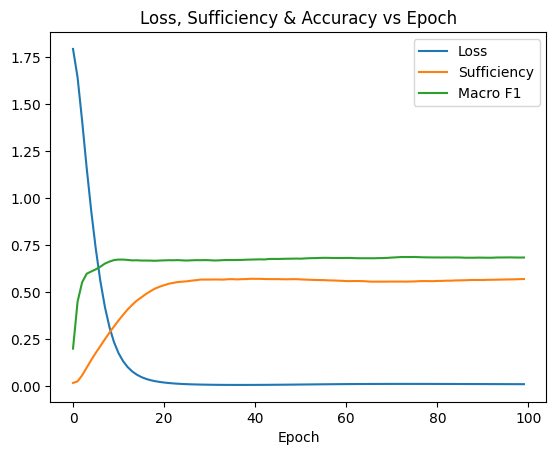

In [7]:
plt.plot([i.item() for i in loss_list], label="Loss")
plt.plot([i for i in cam_sufficiency_list], label="Sufficiency")
plt.plot([i.item() for i in f1_accuracy_list], label="Macro F1")
plt.title("Loss, Sufficiency & Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.legend()

In [8]:
df = pd.DataFrame([(loss_list[i].item(), cam_sufficiency_list[i], f1_accuracy_list[i].item()) for i in range(len(loss_list))], columns=["Loss", "CAM Sufficiency", "F1 Accuracy"])
df.to_csv("Training_for_CAM_sufficiency_CITESEER")

In [12]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")



NameError: name 'gbp_sparsity' is not defined

: 

In [ ]:
ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")

  0%|          | 2/2708 [00:00<07:28,  6.04it/s]

tensor([-0.6574, -0.7225, -0.6013, -0.5233], device='cuda:0')


  0%|          | 3/2708 [00:00<08:56,  5.04it/s]

tensor([-0.5203, -0.3700, -0.7551, -0.9783], device='cuda:0')


  0%|          | 4/2708 [00:00<09:50,  4.58it/s]

tensor([-0.8562, -0.5766, -0.4730, -1.1368, -0.3823,  0.0726], device='cuda:0')


  0%|          | 5/2708 [00:01<10:19,  4.36it/s]

tensor([-1.1077, -0.7583], device='cuda:0')


  0%|          | 6/2708 [00:01<11:07,  4.05it/s]

tensor([-0.5199, -0.6340, -0.2173, -0.2145, -0.0319, -0.6756], device='cuda:0')


  0%|          | 7/2708 [00:01<11:24,  3.95it/s]

tensor([-0.4461, -0.9948, -0.4571, -0.6390], device='cuda:0')


  0%|          | 8/2708 [00:01<11:33,  3.89it/s]

tensor([-0.4153, -0.4828, -0.5654, -0.5037, -0.5363], device='cuda:0')


  0%|          | 9/2708 [00:02<11:29,  3.92it/s]

tensor([-1.7944, -0.2029], device='cuda:0')


  0%|          | 10/2708 [00:02<11:34,  3.88it/s]

tensor([-0.6189, -0.9601, -0.6968, -0.6772], device='cuda:0')


  0%|          | 11/2708 [00:02<11:33,  3.89it/s]

tensor([-0.1621, -0.9223, -0.8898], device='cuda:0')


  0%|          | 12/2708 [00:02<11:29,  3.91it/s]

tensor([-0.8606, -0.7249, -0.6413], device='cuda:0')


  0%|          | 13/2708 [00:03<11:26,  3.92it/s]

tensor([-1.3526, -0.1813, -0.2870], device='cuda:0')


  1%|          | 14/2708 [00:03<11:23,  3.94it/s]

tensor([-0.4200, -0.2410, -0.5283, -0.3195, -0.4002], device='cuda:0')


  1%|          | 15/2708 [00:03<11:19,  3.96it/s]

tensor([-1.0116, -0.7319, -0.6148], device='cuda:0')


  1%|          | 16/2708 [00:03<11:23,  3.94it/s]

tensor([-0.8901, -0.2864,  0.0708, -0.5744, -0.2016, -0.7190], device='cuda:0')


  1%|          | 17/2708 [00:04<11:21,  3.95it/s]

tensor([-0.4788, -0.2618, -0.4735, -0.5339, -0.3104], device='cuda:0')


  1%|          | 18/2708 [00:04<11:25,  3.92it/s]

tensor([-0.9772, -0.3799, -0.5573, -0.5985, -0.6028], device='cuda:0')


  1%|          | 19/2708 [00:04<11:27,  3.91it/s]

tensor([-0.4950, -0.8515, -0.5688, -0.4359, -0.5582, -0.3338], device='cuda:0')


  1%|          | 20/2708 [00:04<11:27,  3.91it/s]

tensor([-0.3018, -1.0444, -0.6570, -0.8701, -0.1670, -0.8772], device='cuda:0')


  1%|          | 21/2708 [00:05<11:25,  3.92it/s]

tensor([-1.0686, -0.9931], device='cuda:0')


  1%|          | 22/2708 [00:05<11:26,  3.91it/s]

tensor([-0.3826,  0.0631, -0.8968, -0.9487, -0.6614, -0.3889], device='cuda:0')


  1%|          | 23/2708 [00:05<11:23,  3.93it/s]

tensor([-1.6130,  0.0976, -0.6573], device='cuda:0')


  1%|          | 24/2708 [00:05<11:31,  3.88it/s]

tensor([-0.3956, -0.7277, -0.6689, -0.2478, -0.2256, -0.1082], device='cuda:0')


  1%|          | 25/2708 [00:06<11:36,  3.85it/s]

tensor([-0.4049, -1.6713], device='cuda:0')


  1%|          | 26/2708 [00:06<11:32,  3.88it/s]

tensor([-0.3425, -0.5798, -0.1702, -0.2315, -0.4489, -0.2593, -0.5921, -0.3989],
       device='cuda:0')


  1%|          | 27/2708 [00:06<11:36,  3.85it/s]

tensor([-0.7113, -0.5180, -0.6471, -0.6454, -0.7941], device='cuda:0')


  1%|          | 28/2708 [00:07<11:32,  3.87it/s]

tensor([-0.5213, -0.5076, -0.3410, -0.5158, -0.4208, -0.0247], device='cuda:0')


  1%|          | 29/2708 [00:07<11:36,  3.85it/s]

tensor([-0.7930, -0.5129, -0.4541, -0.4210, -0.4524], device='cuda:0')


  1%|          | 30/2708 [00:07<11:46,  3.79it/s]

tensor([-1.2461, -0.7360], device='cuda:0')


  1%|          | 31/2708 [00:07<11:57,  3.73it/s]

tensor([-0.2923, -1.5444, -0.3596], device='cuda:0')


  1%|          | 32/2708 [00:08<12:08,  3.67it/s]

tensor([-0.9600, -0.5965, -0.4892, -0.4216,  0.2531, -0.5733, -0.7309],
       device='cuda:0')


  1%|          | 33/2708 [00:08<11:52,  3.76it/s]

tensor([-1.1677, -0.9148], device='cuda:0')


  1%|▏         | 34/2708 [00:08<11:49,  3.77it/s]

tensor([-1.0727, -0.4356, -0.0719, -0.8802, -0.3891], device='cuda:0')


  1%|▏         | 35/2708 [00:08<11:56,  3.73it/s]

tensor([-0.6708, -0.2133, -0.4639, -0.0452, -0.1081, -0.2871, -0.5587, -0.3957,
        -0.1813, -0.5420], device='cuda:0')


  1%|▏         | 36/2708 [00:09<11:49,  3.77it/s]

tensor([-0.9400, -1.0512], device='cuda:0')


  1%|▏         | 37/2708 [00:09<11:40,  3.82it/s]

tensor([-0.4529, -0.4503, -0.3648, -0.6088], device='cuda:0')


  1%|▏         | 38/2708 [00:09<11:38,  3.82it/s]

tensor([-0.5024, -0.2346, -0.5609, -0.3737, -0.3356, -0.3844, -0.2932, -0.3747,
        -0.2052], device='cuda:0')


  1%|▏         | 39/2708 [00:09<11:43,  3.80it/s]

tensor([-1.3181, -0.1349, -0.4077, -0.1352], device='cuda:0')


  1%|▏         | 40/2708 [00:10<11:49,  3.76it/s]

tensor([-0.9254, -0.6111, -0.1048, -0.3196, -0.2110], device='cuda:0')


  2%|▏         | 41/2708 [00:10<11:39,  3.81it/s]

tensor([-0.4832, -0.8994, -0.2025, -0.5024, -0.3493, -0.3469, -0.3100, -0.1292],
       device='cuda:0')


  2%|▏         | 42/2708 [00:10<11:35,  3.83it/s]

tensor([-0.9360, -0.1485, -0.8748, -0.8013], device='cuda:0')


  2%|▏         | 43/2708 [00:10<11:30,  3.86it/s]

tensor([-0.5408, -0.5323, -0.5018, -0.2520, -0.5001], device='cuda:0')


  2%|▏         | 44/2708 [00:11<11:30,  3.86it/s]

tensor([-0.9175, -0.6259, -0.8920], device='cuda:0')


  2%|▏         | 45/2708 [00:11<11:29,  3.86it/s]

tensor([-0.5529, -0.4633, -0.6824, -0.1575, -0.6823, -0.4527, -0.1097],
       device='cuda:0')


  2%|▏         | 46/2708 [00:11<11:26,  3.88it/s]

tensor([-0.7863, -0.6055, -0.3041, -0.7659], device='cuda:0')


  2%|▏         | 47/2708 [00:12<11:24,  3.89it/s]

tensor([-0.6369, -0.1579,  0.0096, -0.2302, -0.7066, -0.8424, -0.8205],
       device='cuda:0')


  2%|▏         | 48/2708 [00:12<11:23,  3.89it/s]

tensor([-0.5954, -0.7689, -1.0760], device='cuda:0')


  2%|▏         | 49/2708 [00:12<11:25,  3.88it/s]

tensor([-0.6883, -0.7915, -0.8190], device='cuda:0')


  2%|▏         | 50/2708 [00:12<11:31,  3.84it/s]

tensor([-0.7514, -0.5609, -0.5929, -0.4977, -0.6895, -0.1147, -0.3839, -0.4977,
        -0.3521, -0.1876], device='cuda:0')


  2%|▏         | 51/2708 [00:13<11:27,  3.86it/s]

tensor([-0.9633, -0.3087, -0.7496], device='cuda:0')


  2%|▏         | 52/2708 [00:13<11:32,  3.84it/s]

tensor([-1.0716, -0.7867], device='cuda:0')


  2%|▏         | 53/2708 [00:13<11:26,  3.87it/s]

tensor([-0.8026, -0.6366, -0.5278, -0.3520, -0.0046, -0.2991, -0.3643],
       device='cuda:0')


  2%|▏         | 54/2708 [00:13<11:26,  3.87it/s]

tensor([-0.2594, -0.6112, -0.5430, -0.0218, -0.8436, -0.6938], device='cuda:0')


  2%|▏         | 55/2708 [00:14<11:26,  3.87it/s]

tensor([-0.6441, -0.4541, -0.7002, -0.3384], device='cuda:0')


  2%|▏         | 56/2708 [00:14<11:24,  3.88it/s]

tensor([-0.5803, -0.7055, -1.0509], device='cuda:0')


  2%|▏         | 57/2708 [00:14<11:28,  3.85it/s]

tensor([-0.9221,  0.3088, -0.4489, -0.3684, -0.2524, -0.0571, -0.5076, -0.1804,
        -0.2160, -0.0491, -0.4002, -0.8905,  0.1593], device='cuda:0')


  2%|▏         | 58/2708 [00:14<11:34,  3.82it/s]

tensor([-0.4749, -0.3756, -0.3725, -0.5048, -0.4532], device='cuda:0')


  2%|▏         | 59/2708 [00:15<11:46,  3.75it/s]

tensor([-1.2448, -0.8058], device='cuda:0')


  2%|▏         | 60/2708 [00:15<11:38,  3.79it/s]

tensor([-0.3131, -1.6650], device='cuda:0')


  2%|▏         | 61/2708 [00:15<11:45,  3.75it/s]

tensor([-0.4681, -0.5944, -0.3451, -0.4504, -0.3806, -0.3288, -0.3684, -0.7651,
        -0.3525, -0.0654, -0.5855], device='cuda:0')


  2%|▏         | 62/2708 [00:15<11:42,  3.77it/s]

tensor([ 0.1158,  0.6875, -1.3673, -0.8284], device='cuda:0')


  2%|▏         | 63/2708 [00:16<11:49,  3.73it/s]

tensor([-0.6049, -0.1793, -0.9846, -0.9551, -0.0148, -0.7559], device='cuda:0')


  2%|▏         | 64/2708 [00:16<11:47,  3.74it/s]

tensor([-0.4189, -1.4566], device='cuda:0')


  2%|▏         | 65/2708 [00:16<11:40,  3.77it/s]

tensor([-1.1445, -0.6135], device='cuda:0')


  2%|▏         | 66/2708 [00:17<11:26,  3.85it/s]

tensor([-0.6229, -0.6396, -0.7113, -0.1714], device='cuda:0')


KeyboardInterrupt: 

50 Epochs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()


for epoch in range(50):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8040


In [ ]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")

100%|██████████| 2708/2708 [12:55<00:00,  3.49it/s]

GBP Sparsity: 1.0
CAM Sparsity: 1.0



In [ ]:

ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")


100%|██████████| 2708/2708 [11:26<00:00,  3.95it/s]

IG Spar: 1.0


100 Epochs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statistics import median
torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset[0].num_nodes, 16)
        self.conv1 = GCNConv(dataset.num_node_features, 16)

        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
graph = to_networkx(data)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.train()


for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7960


In [ ]:
gbp = GuidedBP(model=model)
cam = CAM(model=model)

# getting explanations for each model
gbp_spar = gbp_sparsity(model, graph, data, gbp)
cam_spar = cam_sparsity(model, graph, data, gbp)
print(f"GBP Sparsity: {gbp_spar}\nCAM Sparsity: {cam_spar}\n")

100%|██████████| 2708/2708 [17:32<00:00,  2.57it/s]

GBP Sparsity: 1.0
CAM Sparsity: 1.0



In [ ]:

ig_spar = ig_sparsity(model, graph, data)

print(f"IG Spar: {ig_spar}")

100%|██████████| 2708/2708 [10:33<00:00,  4.28it/s]

IG Spar: 1.0
